In [1]:
import pandas as pd
import numpy as np
import warnings
import matplotlib.pyplot as plt
import seaborn as sns

warnings.filterwarnings(action='ignore')

In [ ]:
import pandas as pd
import numpy as np
from typing import Union, List

class Preprocessor_EDA:
    def __init__(self):
        self.file_path = ""
        self.folder_path = ""
        self.df = pd.DataFrame()

    def __init__(self, data_file_path:str="", folder_path:str=""):
        self.file_path = data_file_path
        self.folder_path = folder_path
        self.df = pd.DataFrame()

    def load_origin_file(self, file_path:str)->None:
        if file_path!="":
            self.file_path = file_path
        self.df = pd.read_csv(self.file_path)

    def drop_columns(self, drop_columns_file_path:str = "drop_columns_0402.txt")->None:
        with open(drop_columns_file_path, mode='r') as f:
            drop_fields = f.readlines()
            drop_fields = [drop_field.strip('\n') for drop_field in drop_fields]
        self.df.drop(columns=drop_fields, inplace=True)

    def __preprocess_target_variable(self, target_variable:str="loan_status")->None:
        # loan_status가 "current", "issued", "policy" 인 행을 필터링하여 삭제
        modified_df = self.df[~self.df[target_variable].isin(['Current', 'Issued', 'Does not meet the credit policy. Status:Fully Paid', 'Does not meet the credit policy. Status:Charged Off'])]
        # risk = 1, safe = 0 으로 처리
        modified_df.loc[modified_df['loan_status'].isin(['Fully Paid', 'In Grace Period']), 'loan_status'] = 0
        modified_df.loc[modified_df['loan_status'].isin(['Charged Off', 'Default', 'Late (16-30 days)', 'Late (31-120 days)']), 'loan_status'] = 1
        modified_df['loan_status'] = modified_df['loan_status'].astype('int')
        self.df = modified_df

    ## 5. 데이터 처리용 함수
    def __delete_suffix(self, term:str)->int:
        '''첫 단어만을 저장하는 함수'''
        term = term.strip().split()[0]
        return int(term)

    def __delete_suffix_percentage(self, term:str)->float:
        '''%를 자르는 함수'''
        term = term.strip('%')
        return float(term)

    def __fill_na_with_value(self, columns:List[str], filling_value:Union[str, int])->None:
        '''
        df: dataframe to fill NA
        column_name : column name to change NA values
        filling_value : value type or just value to fill column's NA
        '''
        for column_name in columns:
            if filling_value=="mode":
                mode_value = self.df[column_name].mode()[0]
            elif filling_value=="median":
                mode_value = self.df[column_name].median()
            else:
                mode_value = filling_value
            self.df[column_name].fillna(mode_value, inplace=True)

    def __preprocessing_na(self)->None:
        ## 결측 처리
        # 결측 개수가 1천 건 이하인 경우는 해당 데이터(row) 삭제
        self.df.dropna(subset=['chargeoff_within_12_mths','collections_12_mths_ex_med','dti',
                                                'pub_rec_bankruptcies','revol_util','tax_liens'], inplace=True)

        # A1. 최빈값 대체
        self.__fill_na_with_value(columns=['mo_sin_old_il_acct', 'mths_since_recent_bc', 'mths_since_recent_inq', 'emp_length'], filling_value='mode')

        # A2. 중앙값 대체
        self.__fill_na_with_value(columns=['bc_open_to_buy'], filling_value='median')
        # B. 2015년 대체
        # is_after_2015 컬럼 생성. all_util 변수를 기준으로 사용
        self.df['is_after_2015'] = self.df['all_util'].apply(lambda x: 0 if pd.isnull(x) else 1)
        # 결측값을 0으로 채우기

        # C. 2012년 대체
        # is_after_2012 컬럼 생성. pct_tl_nvr_dlq 변수를 기준으로 사용
        self.df['is_after_2012'] = self.df['pct_tl_nvr_dlq'].apply(lambda x: 0 if pd.isnull(x) else 1)
        # D. 결측 0 대체
        self.__fill_na_with_value(columns=['annual_inc_joint','dti_joint','revol_bal_joint', 'open_acc_6m',
                                           'open_act_il', 'open_il_12m', 'open_il_24m', 'total_bal_il',
                                           'open_rv_12m', 'open_rv_24m', 'max_bal_bc', 'all_util', 'total_cu_tl', 'mths_since_rcnt_il',
                                           'tot_cur_bal', 'total_rev_hi_lim', 'mo_sin_old_rev_tl_op',
                                           'mo_sin_rcnt_rev_tl_op', 'mo_sin_rcnt_tl', 'mort_acc', 'num_bc_sats', 'num_bc_tl',
                                           'num_accts_ever_120_pd', 'num_actv_bc_tl', 'num_actv_rev_tl', 'num_il_tl',
                                           'num_op_rev_tl','num_rev_accts','num_rev_tl_bal_gt_0','num_sats','num_tl_120dpd_2m','num_tl_30dpd',
                                           'num_tl_90g_dpd_24m','num_tl_op_past_12m','pct_tl_nvr_dlq','tot_hi_cred_lim','total_bal_ex_mort',
                                           'total_bc_limit','total_il_high_credit_limit'], filling_value=0)


    def __convert_object_to_numeric(self, column_name:str)->pd.DataFrame:
        unique_values = sorted(self.df[column_name].unique())
        value_map = {value:index for index, value in enumerate(unique_values)}
        self.df[column_name] = self.df[column_name].apply(lambda x:value_map.get(x))
        return self.df

    def __convert_object_to_one_hot(self, column_name:str)->None:
        encoded = pd.get_dummies(self.df[column_name])
        self.df = pd.concat([self.df, encoded], axis=1)
        self.df.drop(column_name, axis=1, inplace=True)

    def __preprocessing_objects(self)->None:
        ## TODO : 'addr_state' 필드 해결하기
        # term
        self.df['term'] = self.df['term'].apply(self.__delete_suffix)
        # emp_length
        self.df['emp_length'] = self.df['emp_length'].apply(lambda x: x.replace(' years','').replace(' year','').replace('+','').replace('< 1', '0'))
        self.df['emp_length'] = self.df['emp_length'].astype(int)
        # revol_util
        self.df['revol_util'] = self.df['revol_util'].apply(self.__delete_suffix_percentage)

        ## numeric
        # application_type
        # self.df = self.__convert_object_to_numeric('application_type')
        # sub_grade
        self.df = self.__convert_object_to_numeric('sub_grade')

        ## one-hot
        # home_ownership
        self.df['home_ownership'] = self.df['home_ownership'].replace(['ANY', 'OTHER', 'NONE'], 'OTHERS')


    def preprocess(self)->None:
        # loan_status 제외 모든 column이 결측치(na)인 행 제거 (1개 행 제거됨)
        self.df.dropna(subset=self.df.columns.difference(['loan_status']),how='all', inplace=True)
        self.__preprocess_target_variable()
        # 결측치 제거
        self.__preprocessing_na()
        ## object 처리하기
        self.__preprocessing_objects()
        # index 재설정
        self.df.reset_index(drop=True, inplace=True)
        self.df.dropna(subset=self.df.columns.difference(['loan_status']),how='all', inplace=True)

    def get_df(self)->pd.DataFrame:
        return self.df

In [ ]:
p = Preprocessor_EDA()
# lending_club_2020_train.csv 파일이 있는 절대 경로 혹은 상대 경로를 명시해주세요
p.load_origin_file(file_path="YOUR_DATA_FILE_PATH")
# drop_columns.txt 파일의 위치를 명시해주세요
p.drop_columns(drop_columns_file_path='YOUR_TXTFILE_PATH_WITH_DROP_COLUMNS_INFO')
# preprocess를 돌리면, addr_state를 제외한 object field 및, na(결측치) 처리됩니다.
p.preprocess()

In [ ]:
df = p.get_df()
columns_with_na = df.columns[df.isna().any()].tolist()
columns_with_na

['acc_open_past_24mths', 'avg_cur_bal']

In [ ]:
df = df.drop(columns=columns_with_na)

In [ ]:
object_variables = [col for col in df.select_dtypes('object')]
numeric_variables = [col for col in df.select_dtypes('float')]
numeric_data = df[numeric_variables]

In [ ]:
numeric_variables

['loan_amnt',
 'annual_inc',
 'dti',
 'delinq_2yrs',
 'fico_range_low',
 'fico_range_high',
 'inq_last_6mths',
 'open_acc',
 'pub_rec',
 'revol_bal',
 'revol_util',
 'total_acc',
 'collections_12_mths_ex_med',
 'annual_inc_joint',
 'dti_joint',
 'acc_now_delinq',
 'tot_cur_bal',
 'open_acc_6m',
 'open_act_il',
 'open_il_12m',
 'open_il_24m',
 'mths_since_rcnt_il',
 'total_bal_il',
 'open_rv_12m',
 'open_rv_24m',
 'max_bal_bc',
 'all_util',
 'total_rev_hi_lim',
 'total_cu_tl',
 'bc_open_to_buy',
 'chargeoff_within_12_mths',
 'delinq_amnt',
 'mo_sin_old_il_acct',
 'mo_sin_old_rev_tl_op',
 'mo_sin_rcnt_rev_tl_op',
 'mo_sin_rcnt_tl',
 'mort_acc',
 'mths_since_recent_bc',
 'mths_since_recent_inq',
 'num_accts_ever_120_pd',
 'num_actv_bc_tl',
 'num_actv_rev_tl',
 'num_bc_sats',
 'num_bc_tl',
 'num_il_tl',
 'num_op_rev_tl',
 'num_rev_accts',
 'num_rev_tl_bal_gt_0',
 'num_sats',
 'num_tl_120dpd_2m',
 'num_tl_30dpd',
 'num_tl_90g_dpd_24m',
 'num_tl_op_past_12m',
 'pct_tl_nvr_dlq',
 'pub_rec_ban

In [ ]:
print(len(df.columns))
print(df.columns)

72
Index(['loan_amnt', 'term', 'sub_grade', 'emp_length', 'home_ownership',
       'annual_inc', 'verification_status', 'loan_status', 'purpose',
       'addr_state', 'dti', 'delinq_2yrs', 'fico_range_low', 'fico_range_high',
       'inq_last_6mths', 'open_acc', 'pub_rec', 'revol_bal', 'revol_util',
       'total_acc', 'collections_12_mths_ex_med', 'application_type',
       'annual_inc_joint', 'dti_joint', 'acc_now_delinq', 'tot_cur_bal',
       'open_acc_6m', 'open_act_il', 'open_il_12m', 'open_il_24m',
       'mths_since_rcnt_il', 'total_bal_il', 'open_rv_12m', 'open_rv_24m',
       'max_bal_bc', 'all_util', 'total_rev_hi_lim', 'total_cu_tl',
       'bc_open_to_buy', 'chargeoff_within_12_mths', 'delinq_amnt',
       'mo_sin_old_il_acct', 'mo_sin_old_rev_tl_op', 'mo_sin_rcnt_rev_tl_op',
       'mo_sin_rcnt_tl', 'mort_acc', 'mths_since_recent_bc',
       'mths_since_recent_inq', 'num_accts_ever_120_pd', 'num_actv_bc_tl',
       'num_actv_rev_tl', 'num_bc_sats', 'num_bc_tl', 'num_il_tl

데이터 처리 완료!

- 상관 계수를 알아보기 위해서 히트맵 확인

<Axes: >

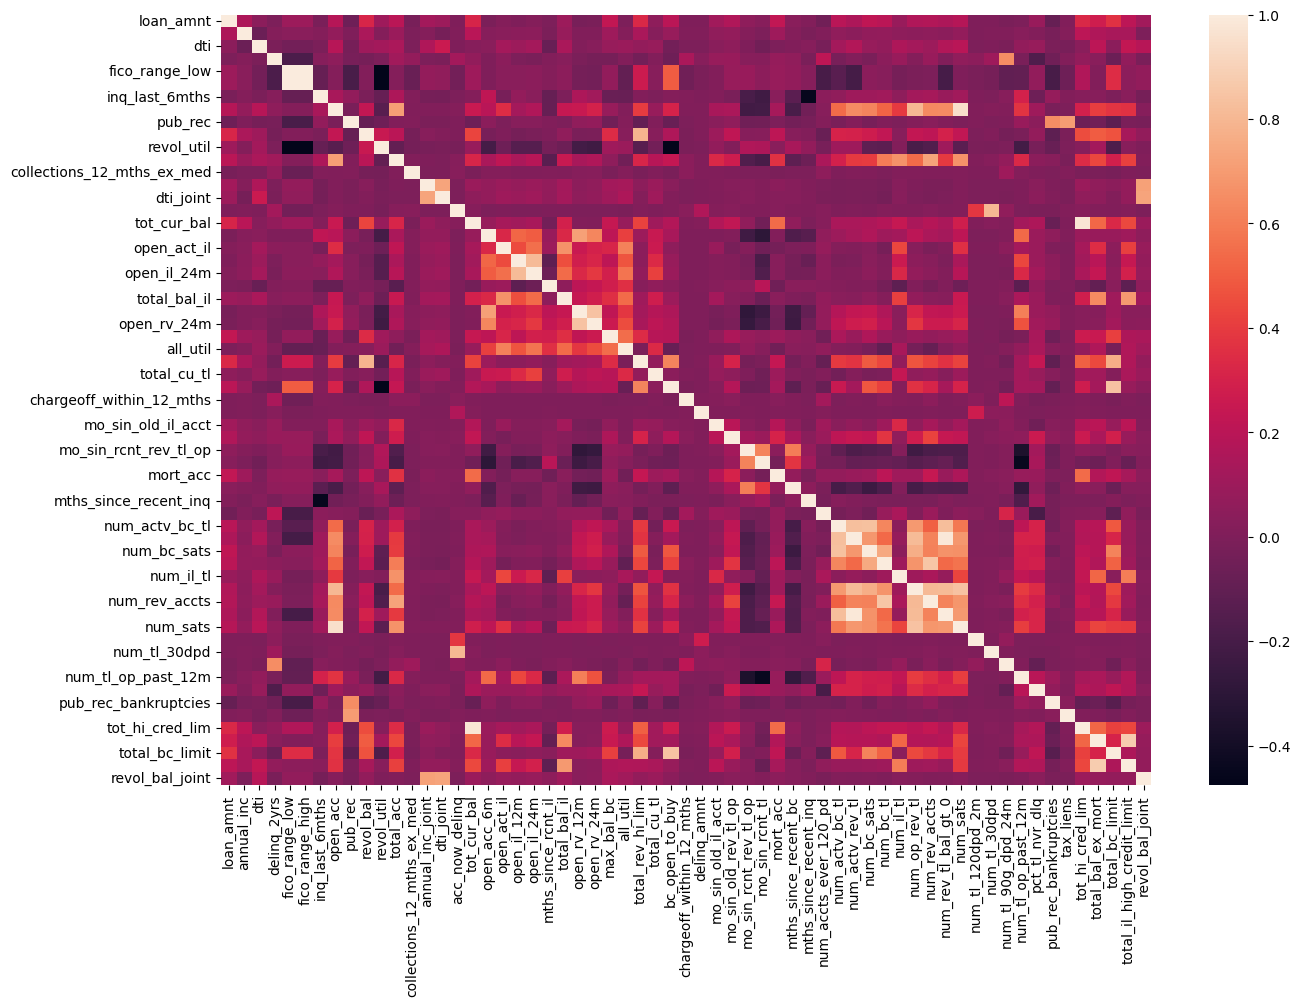

In [ ]:
plt.figure(figsize=(15,10))
sns.heatmap(numeric_data.corr()) #, annot=True)

In [ ]:
# 상관 행렬 계산
correlation_matrix = numeric_data.corr()

# 상관 관계가 높은 순서쌍을 추출
sorted_pairs = correlation_matrix.unstack().sort_values(ascending=False)

# 중복된 쌍 제거
sorted_pairs = sorted_pairs[sorted_pairs != 1]

In [ ]:
sorted_pairs[::2].head(20)

fico_range_low       fico_range_high               1.000000
num_rev_tl_bal_gt_0  num_actv_rev_tl               0.984563
tot_cur_bal          tot_hi_cred_lim               0.975584
num_sats             open_acc                      0.953054
total_bal_ex_mort    total_il_high_credit_limit    0.877633
num_rev_accts        num_bc_tl                     0.853953
num_op_rev_tl        num_sats                      0.841477
total_bc_limit       bc_open_to_buy                0.840342
open_rv_24m          open_rv_12m                   0.839684
num_bc_sats          num_actv_bc_tl                0.833731
num_actv_bc_tl       num_actv_rev_tl               0.831393
num_rev_tl_bal_gt_0  num_actv_bc_tl                0.825599
                     num_op_rev_tl                 0.815612
num_actv_rev_tl      num_op_rev_tl                 0.811539
open_il_24m          open_il_12m                   0.810325
num_op_rev_tl        num_rev_accts                 0.807124
open_acc             num_op_rev_tl      

In [ ]:
# 로그 변환을 위한 함수 정의
def log_transform(x):
    return np.log(x + 1)  # 0 이하의 값이 없도록 1을 더해줌

- 각 수치형 변수의 box plot, kdeplot
- log 변환한 데이터의 plot도 추가

loan_amnt


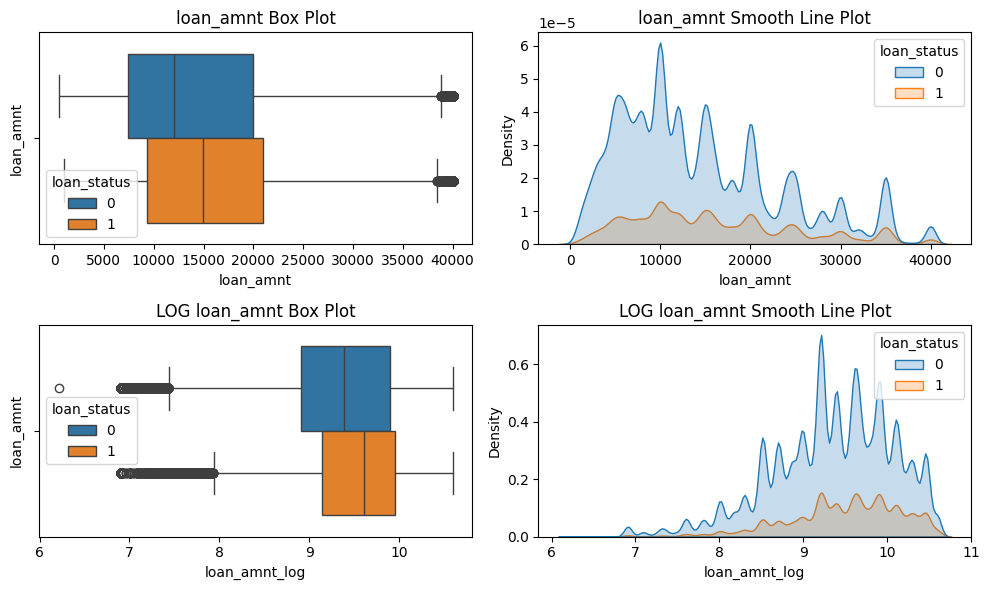

term


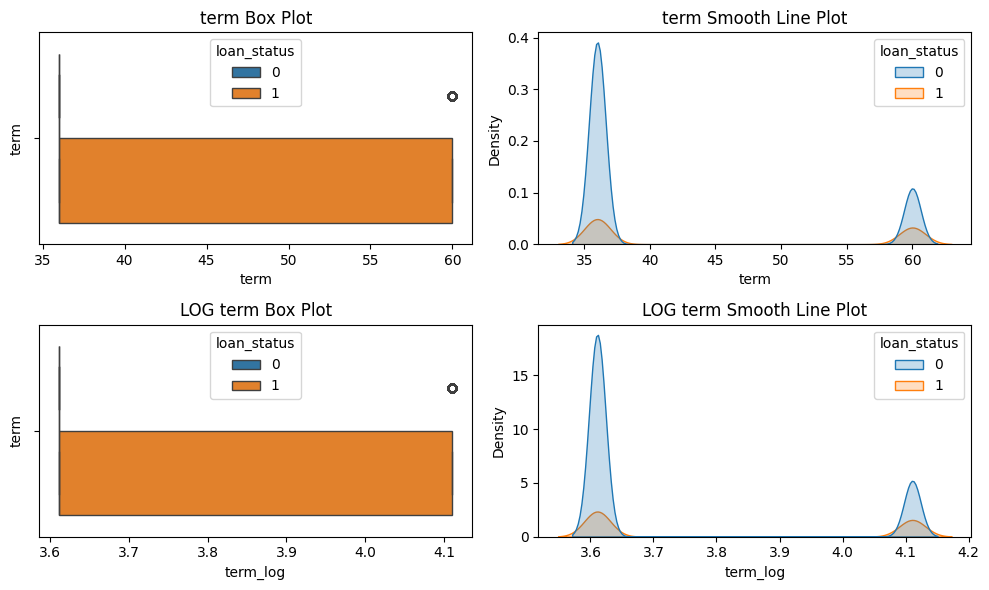

sub_grade


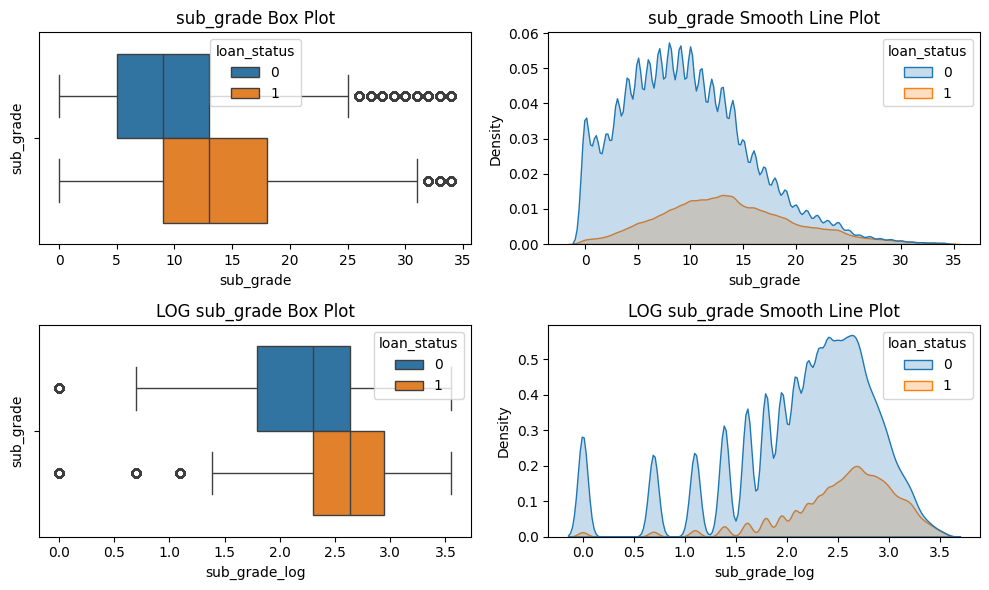

emp_length


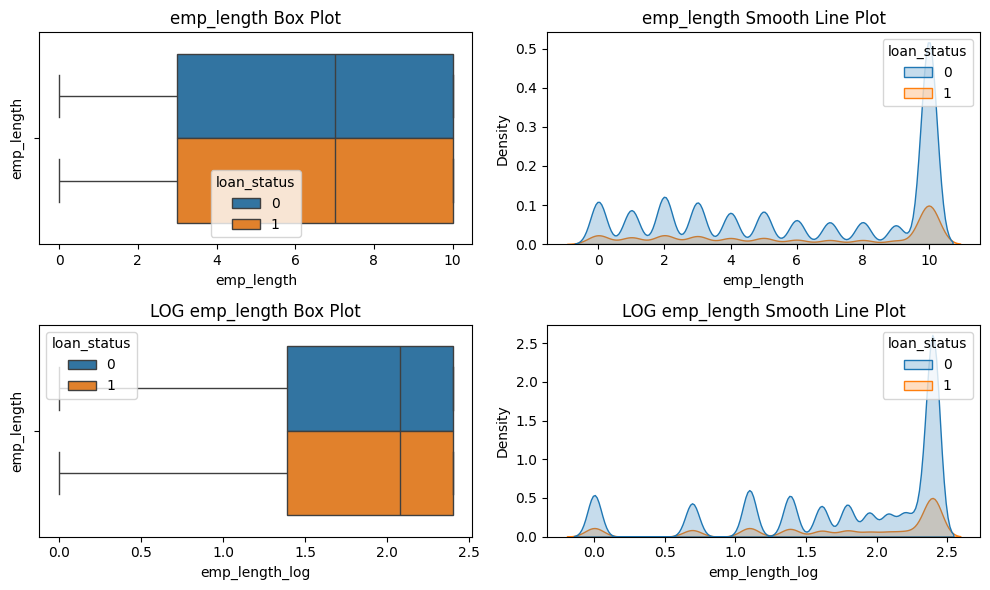

annual_inc


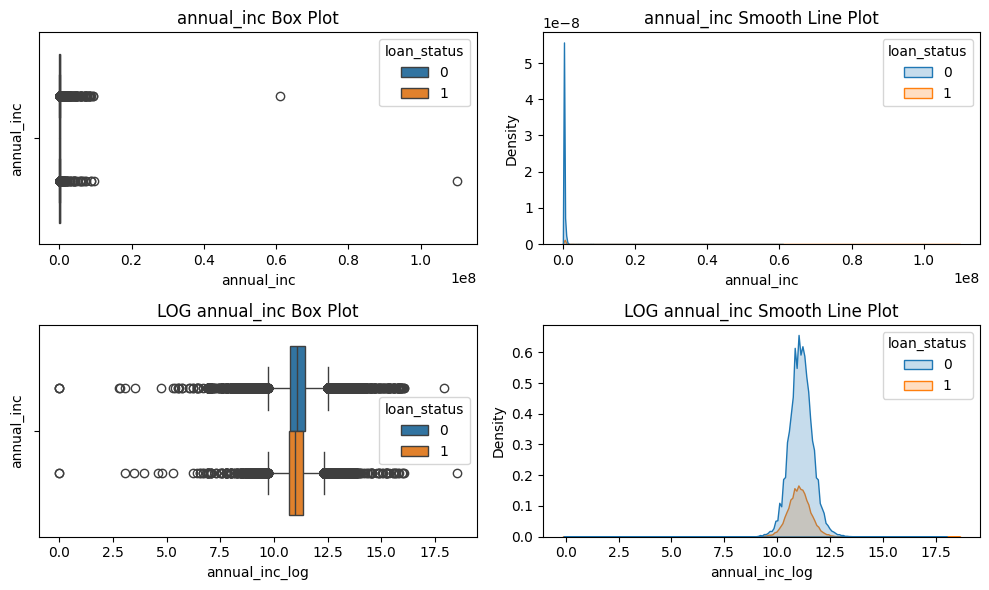

dti


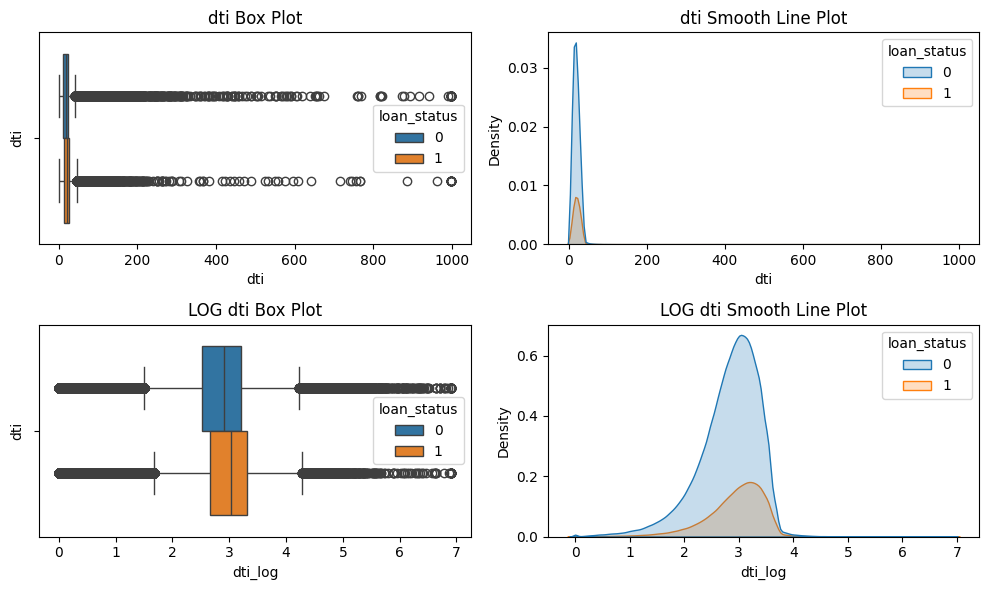

delinq_2yrs


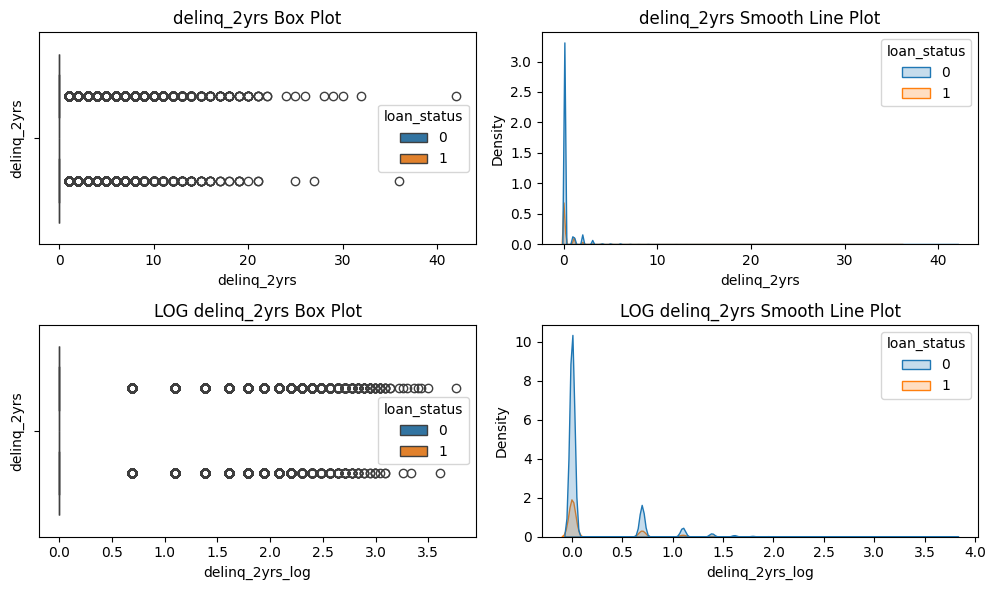

fico_range_low


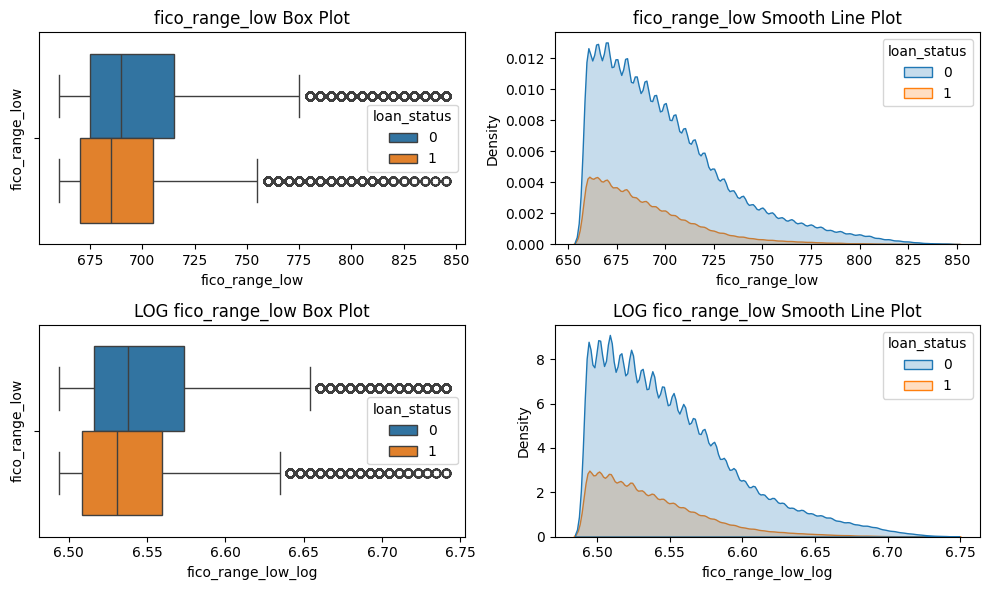

fico_range_high


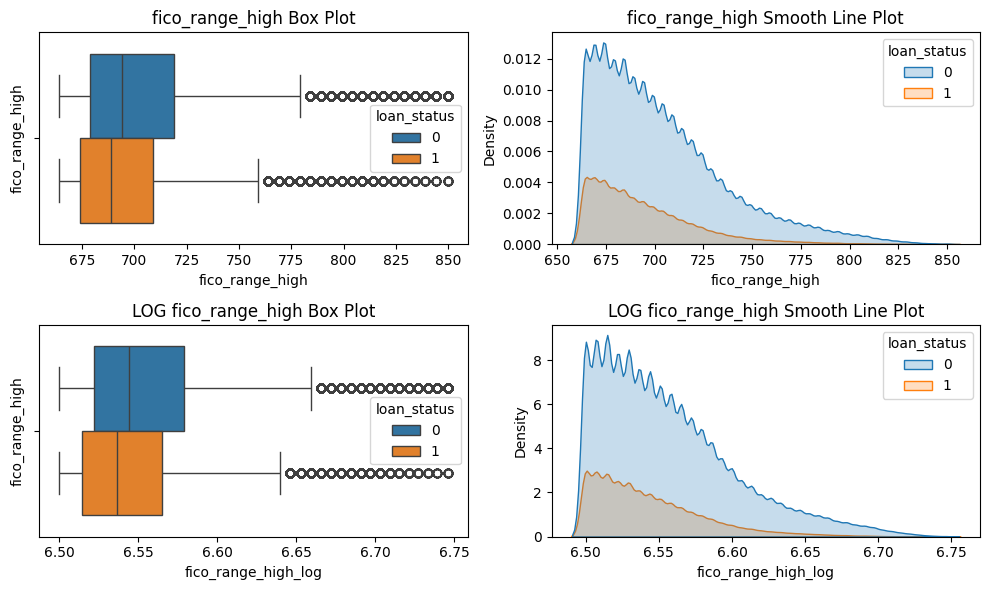

inq_last_6mths


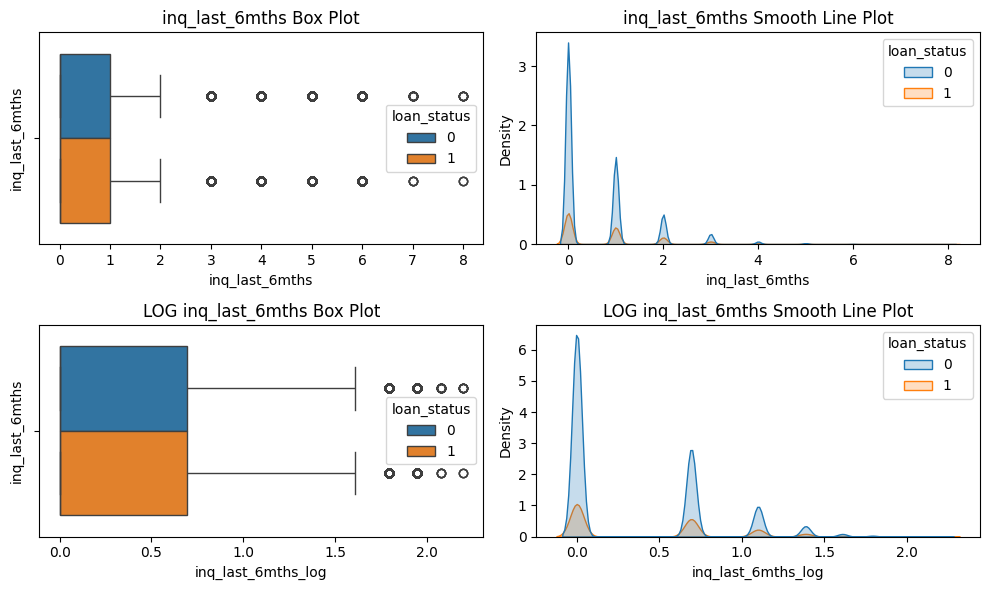

open_acc


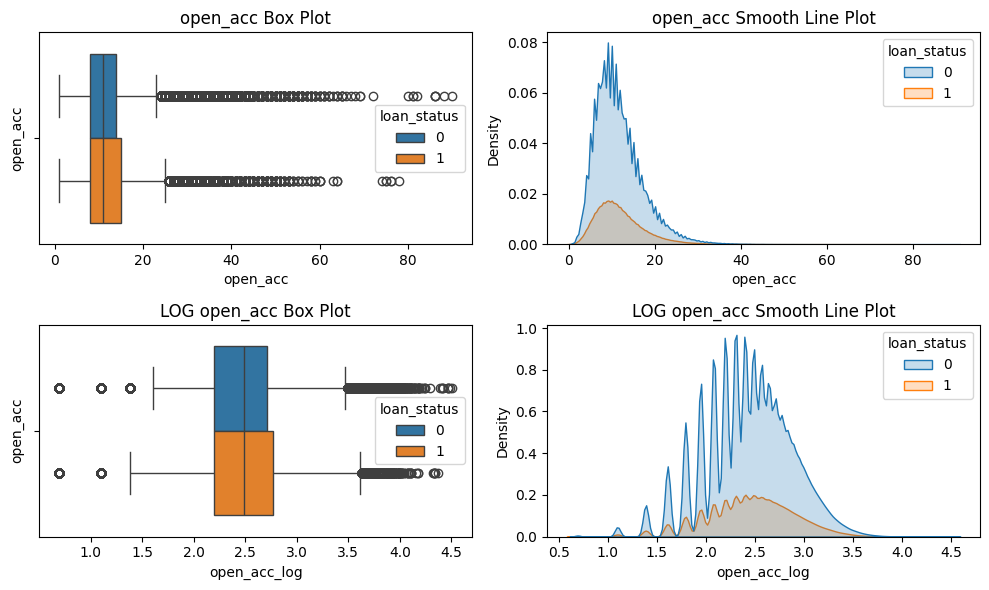

pub_rec


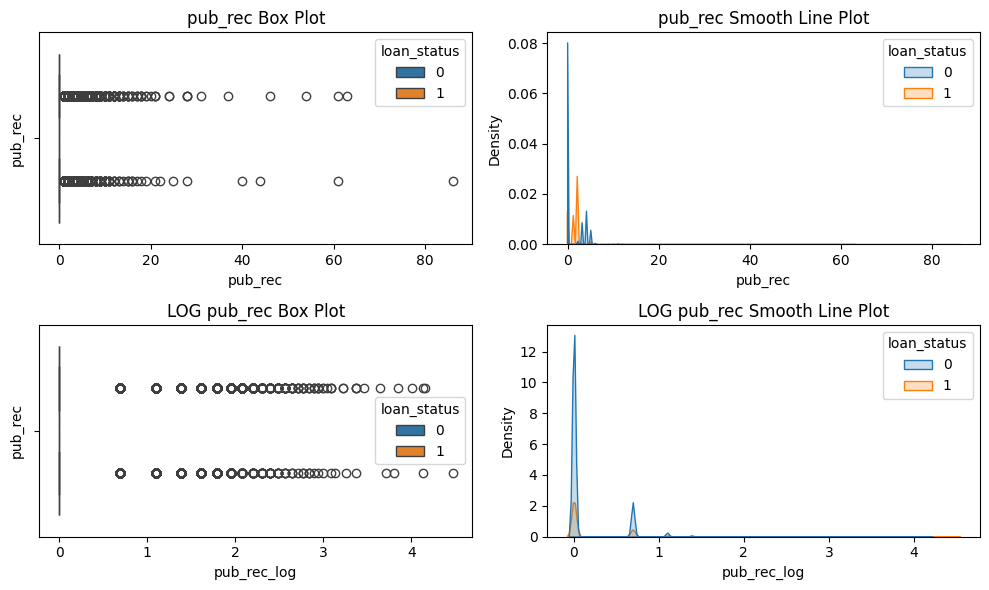

revol_bal


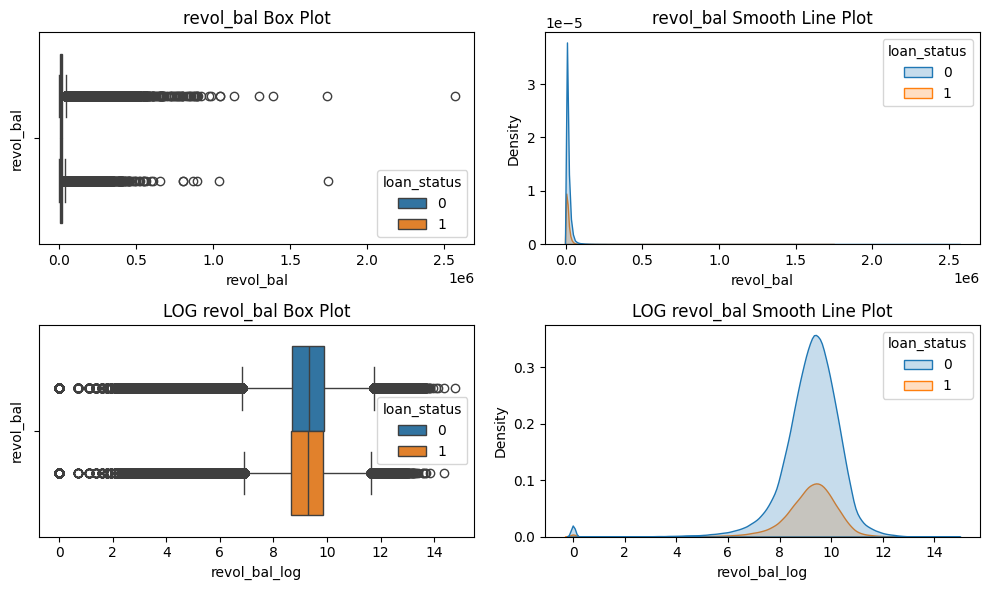

revol_util


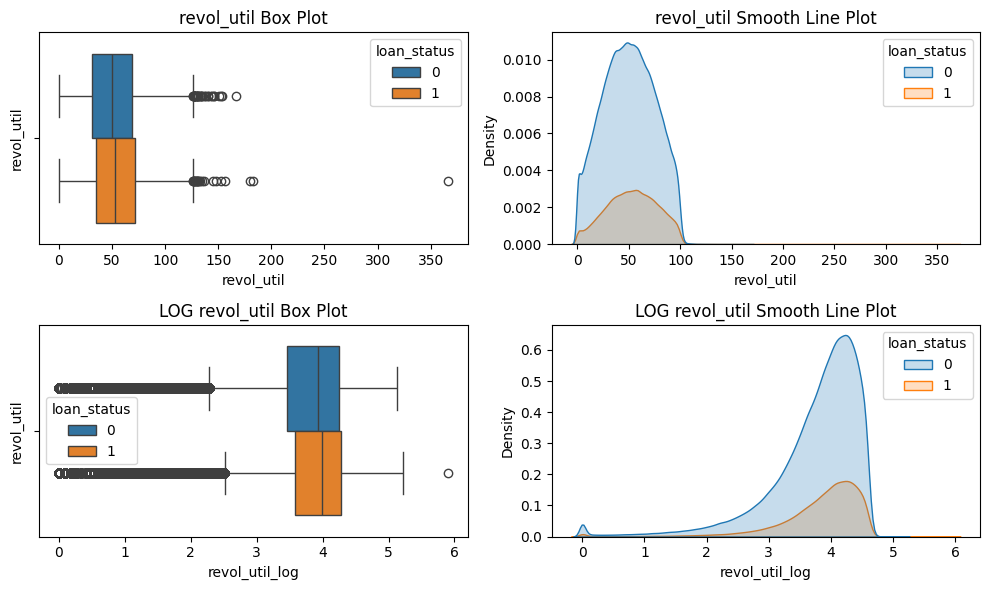

total_acc


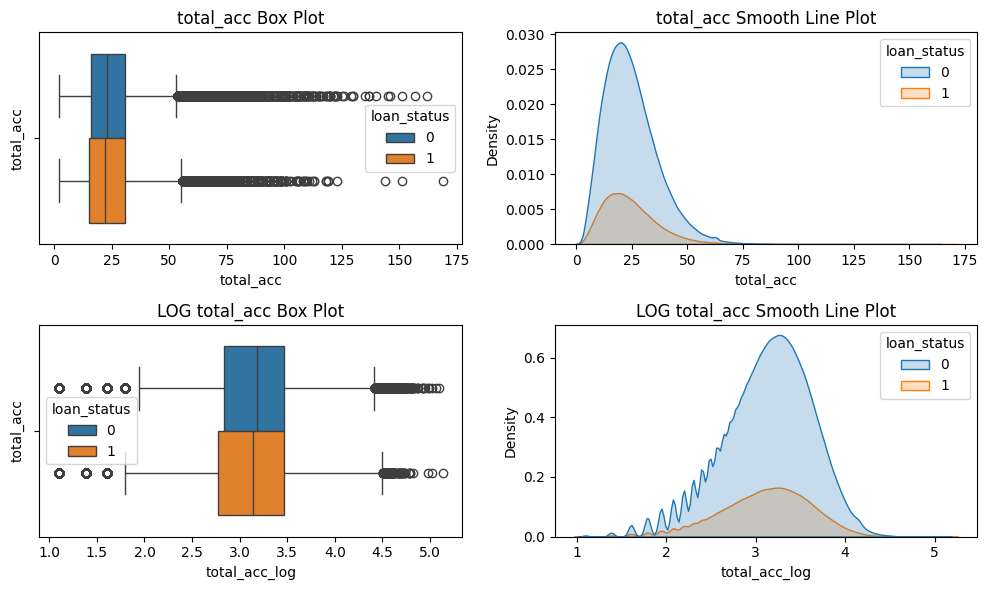

collections_12_mths_ex_med


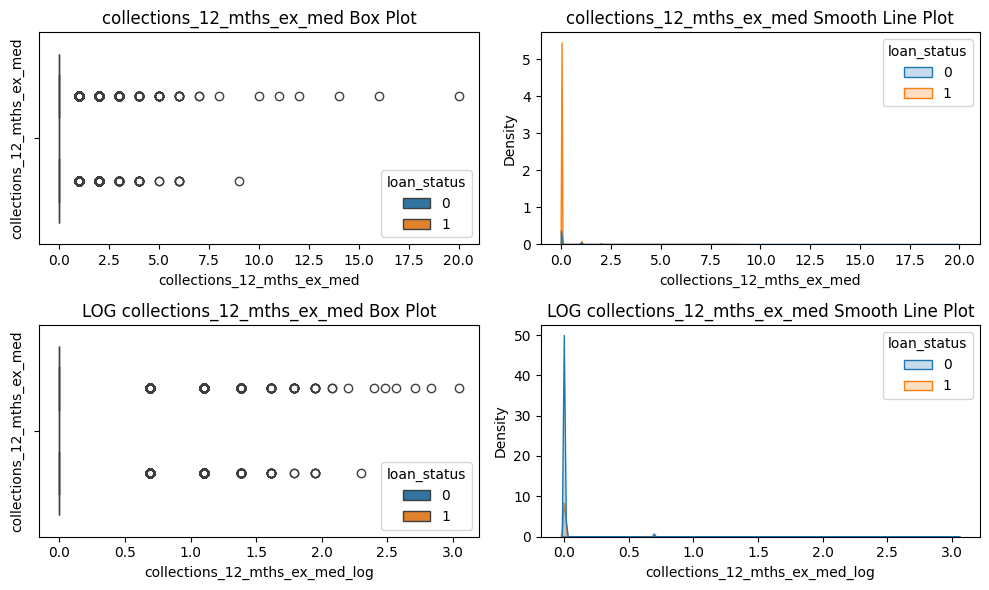

annual_inc_joint


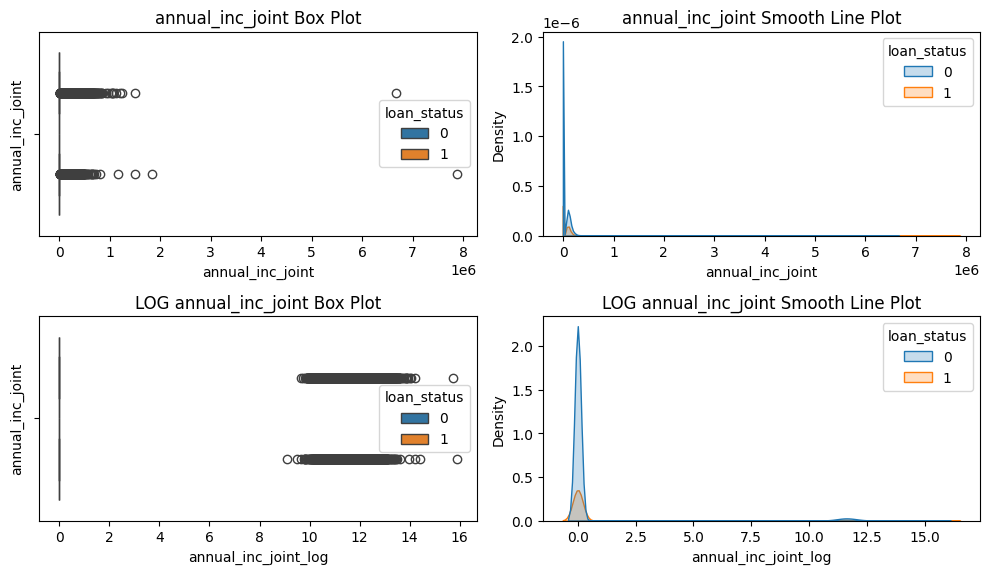

dti_joint


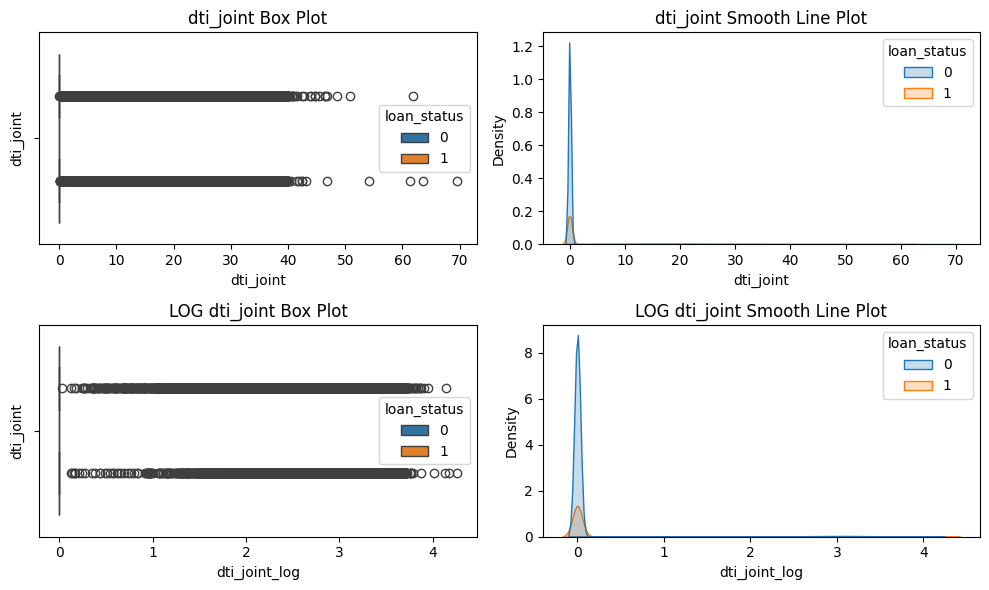

acc_now_delinq


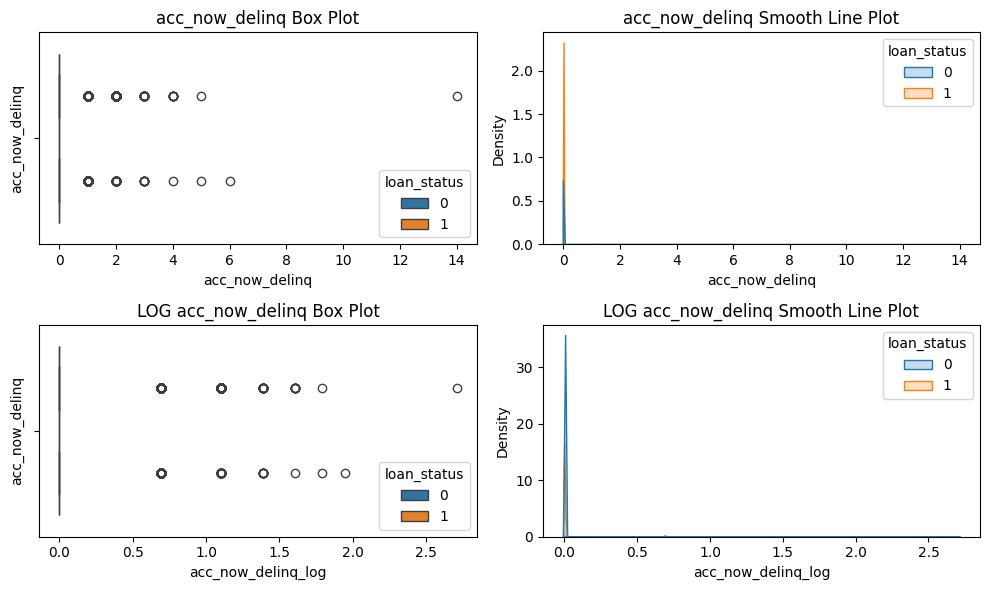

tot_cur_bal


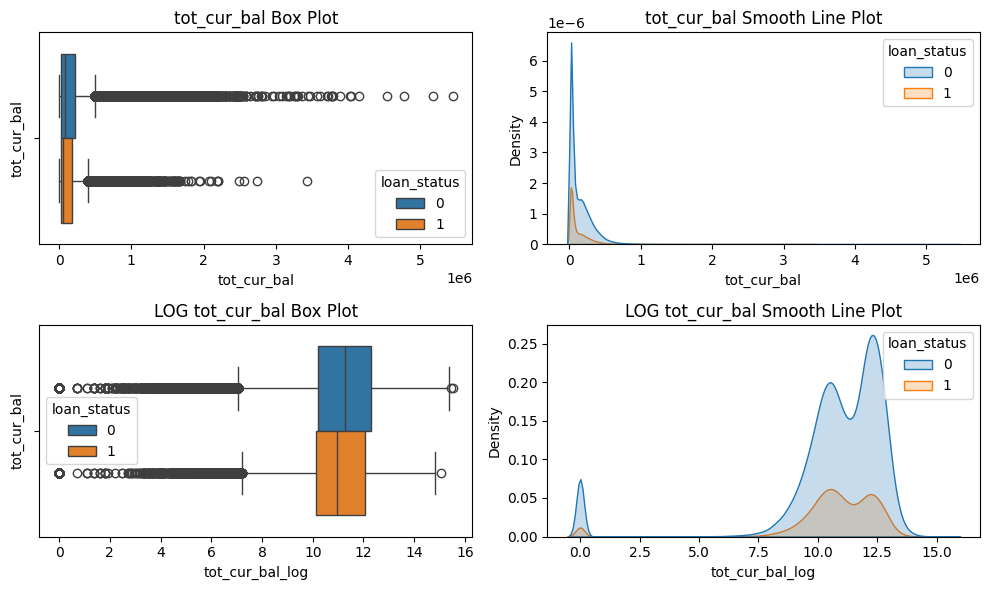

open_acc_6m


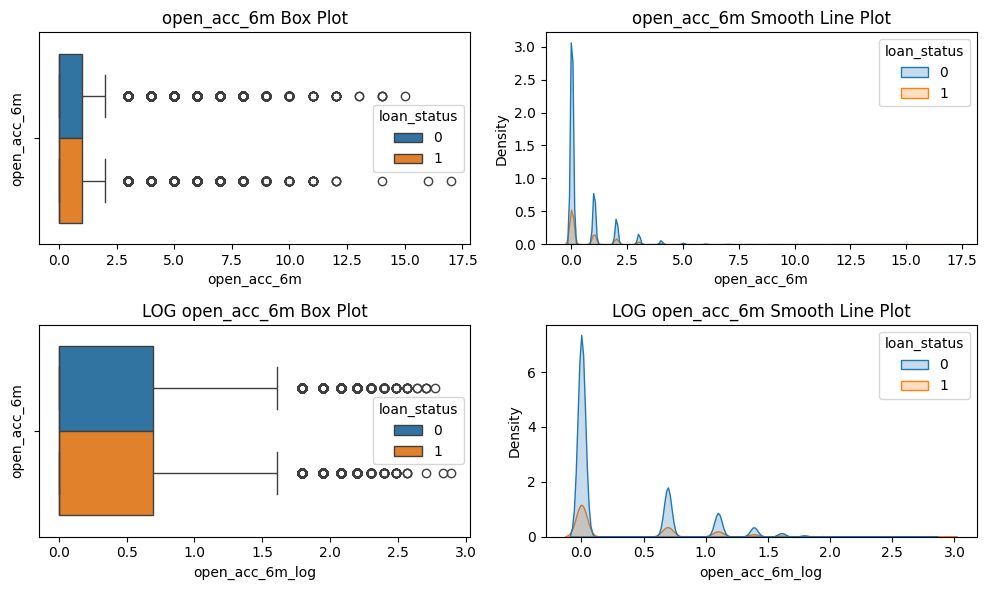

open_act_il


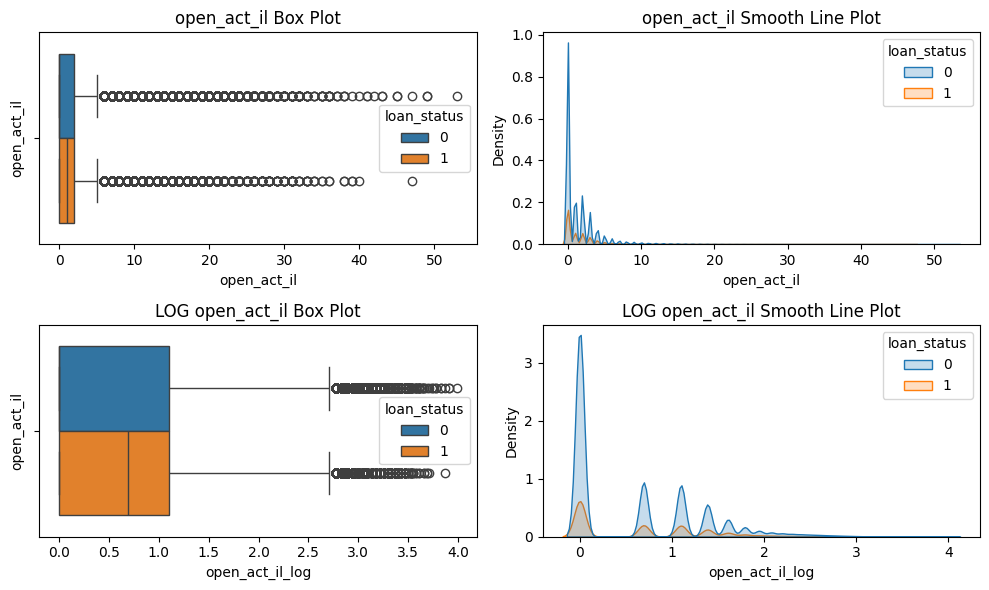

open_il_12m


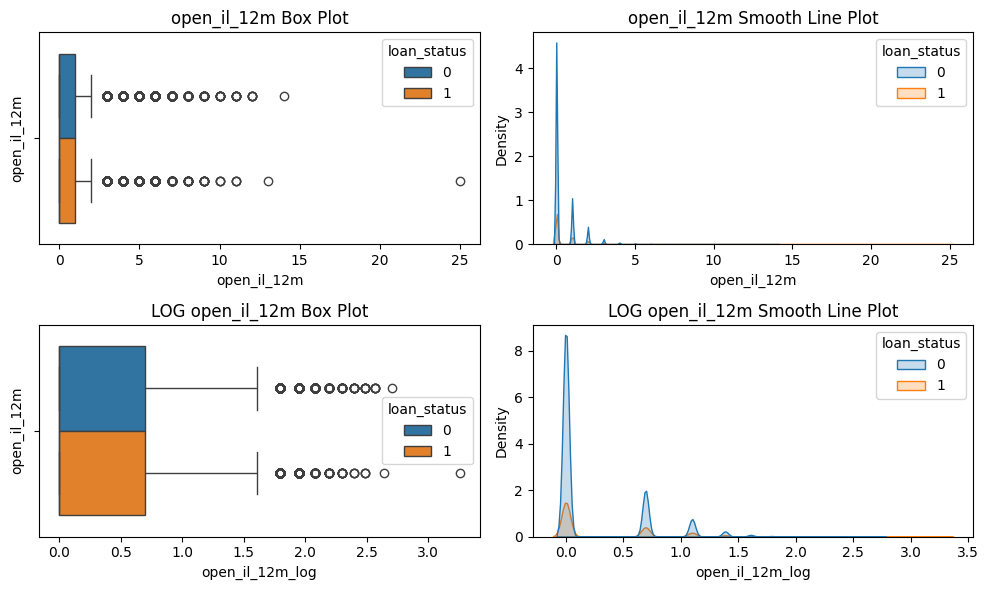

open_il_24m


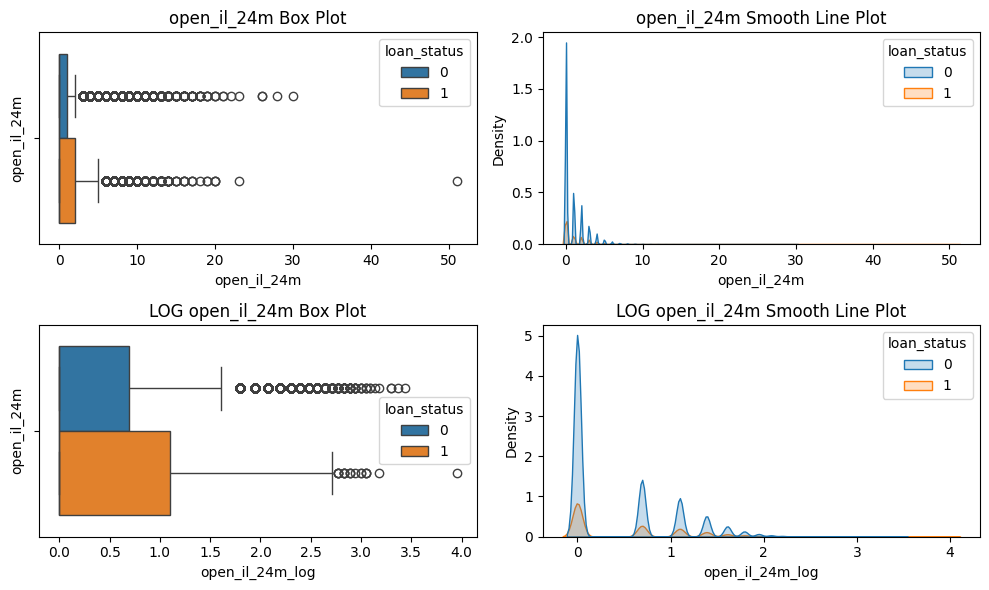

mths_since_rcnt_il


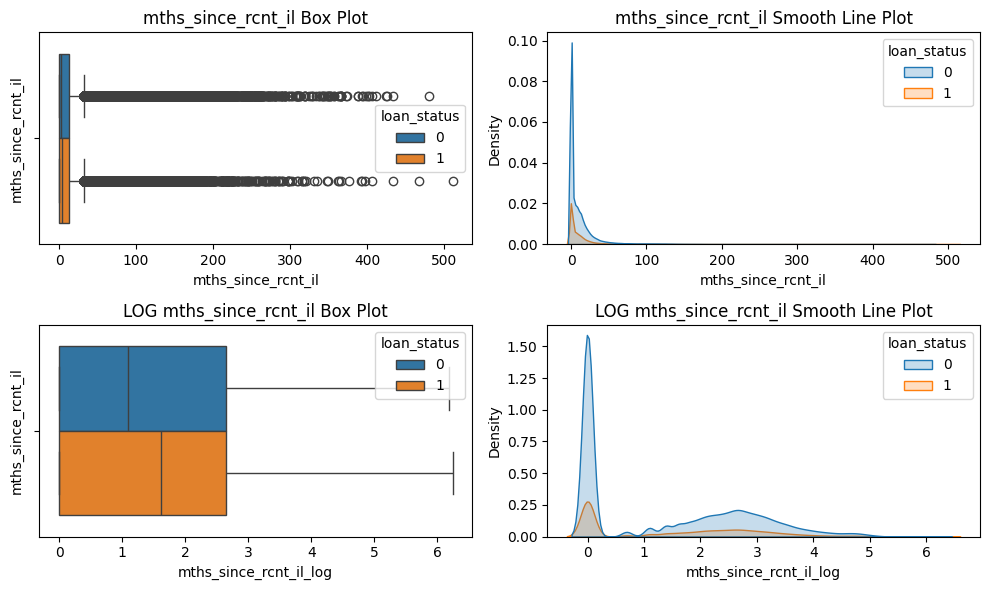

total_bal_il


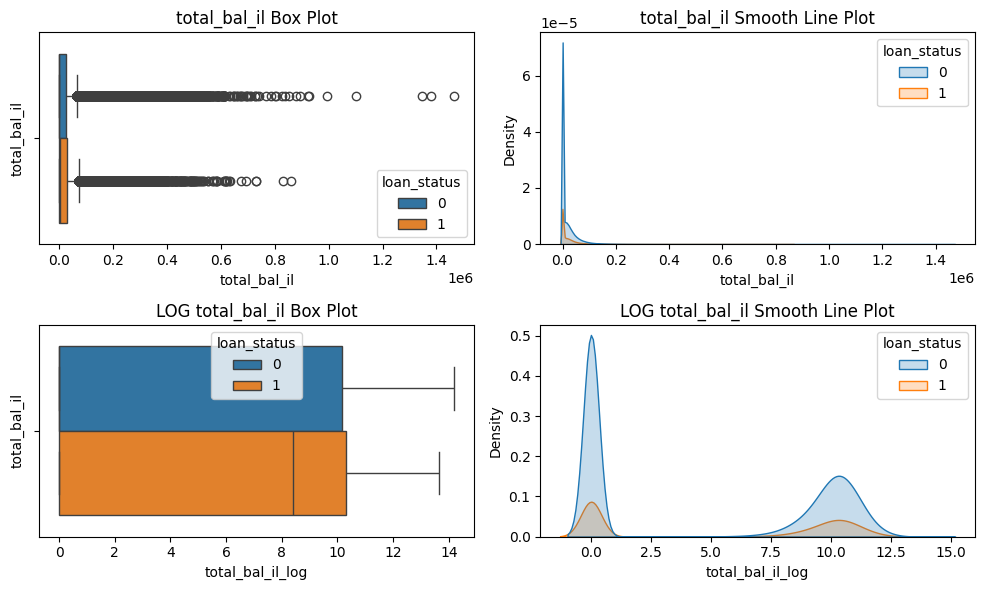

open_rv_12m


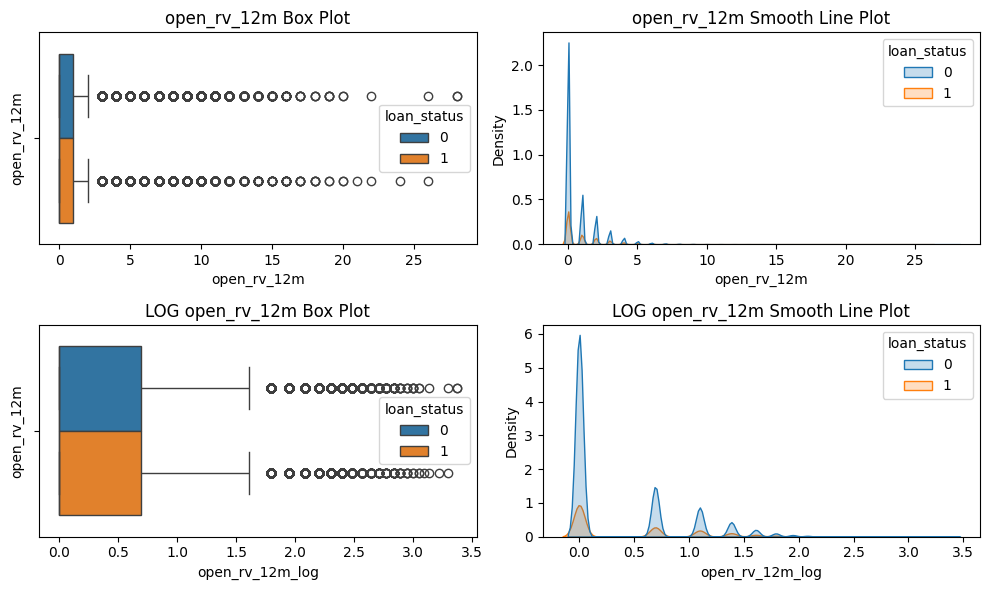

open_rv_24m


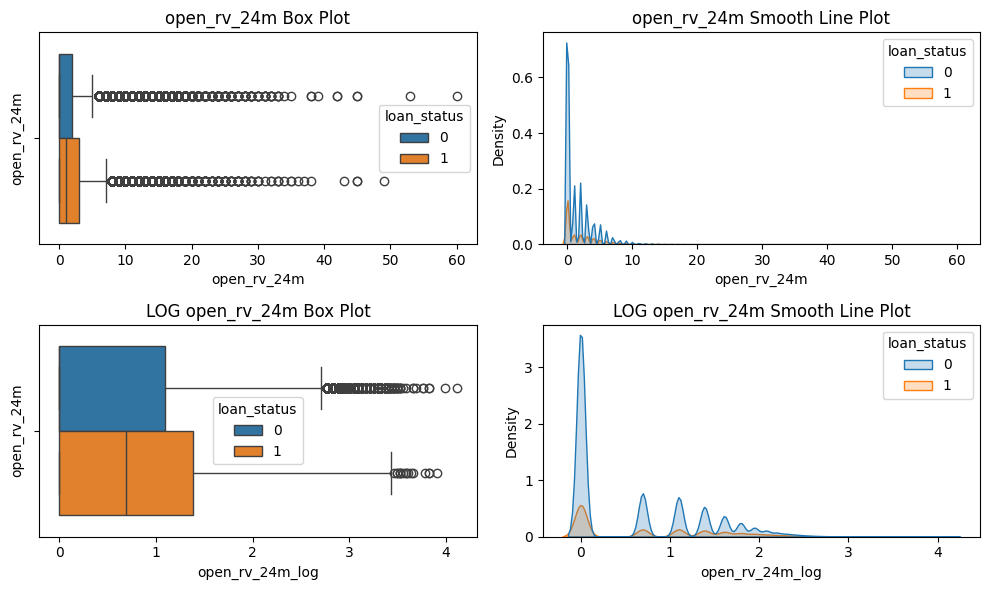

max_bal_bc


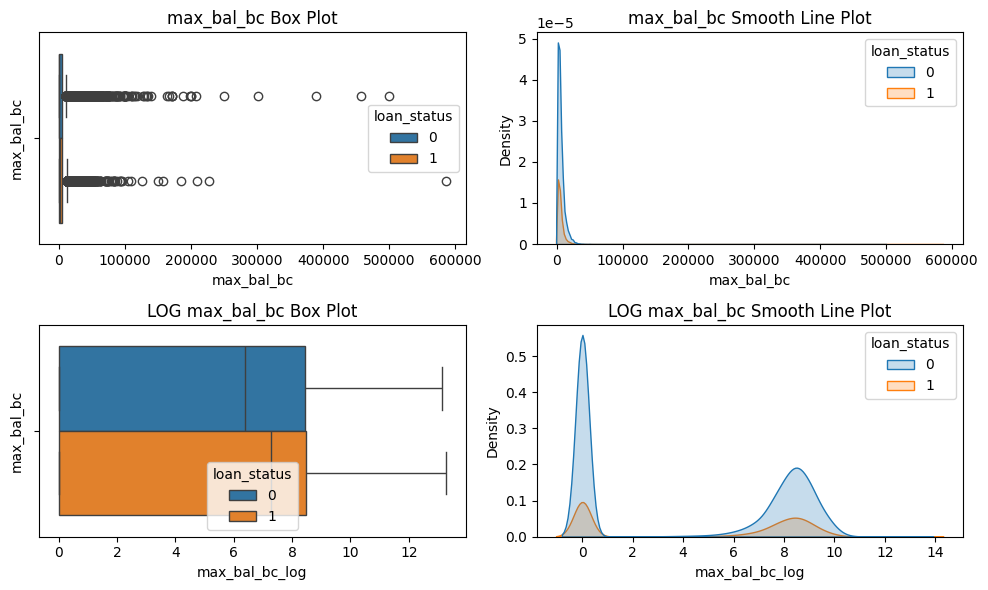

all_util


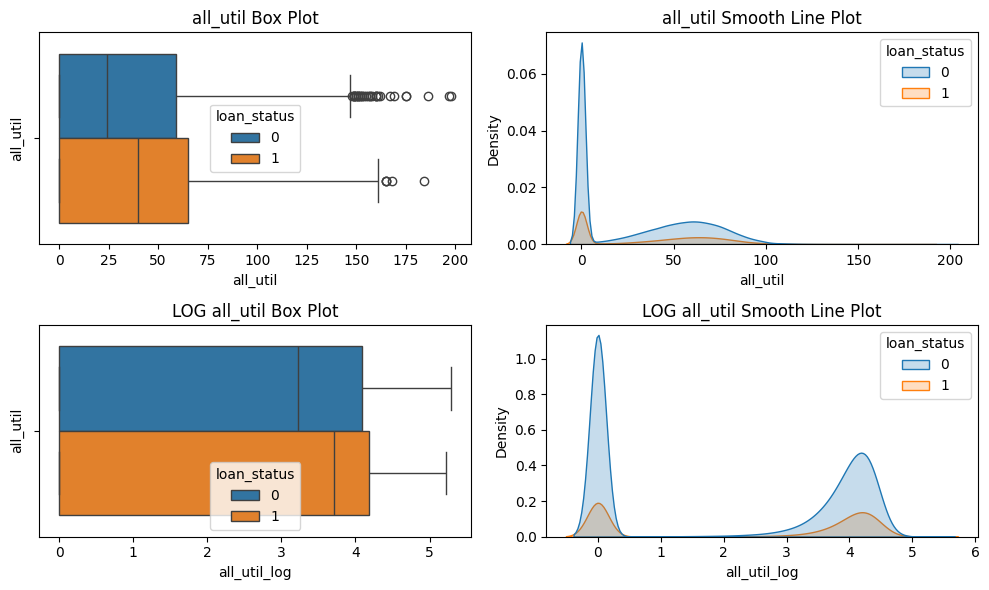

total_rev_hi_lim


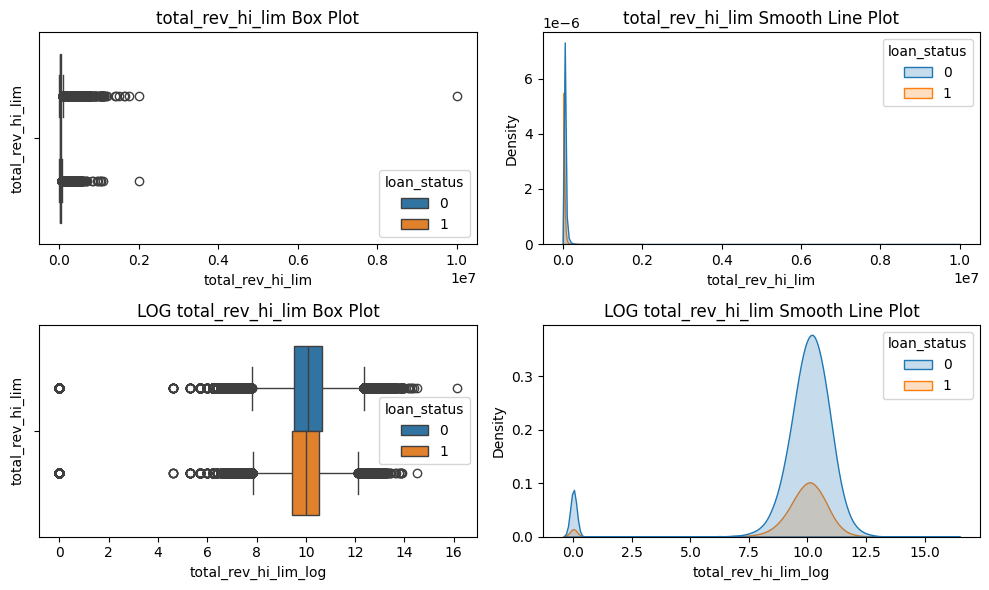

total_cu_tl


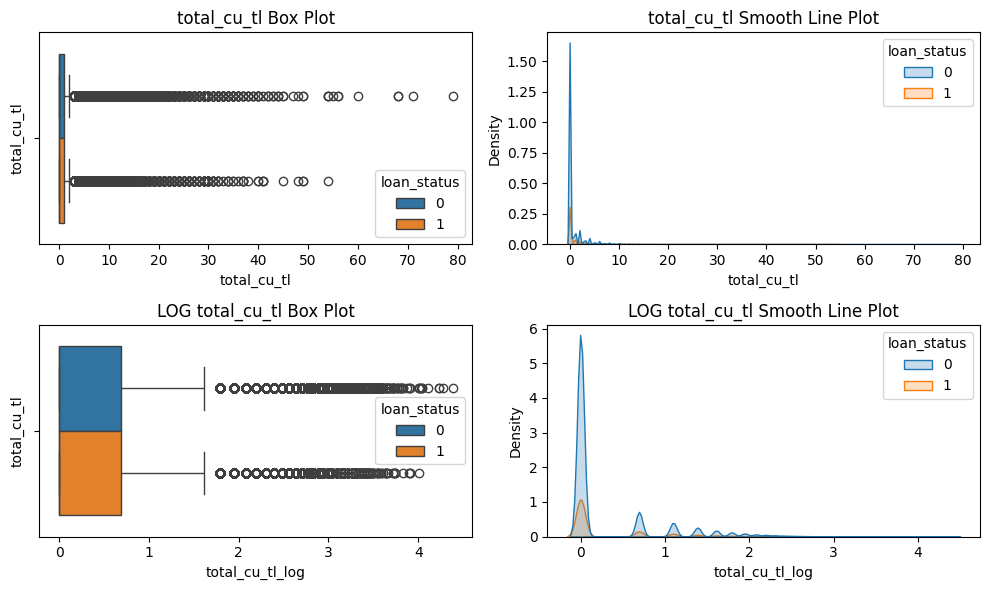

bc_open_to_buy


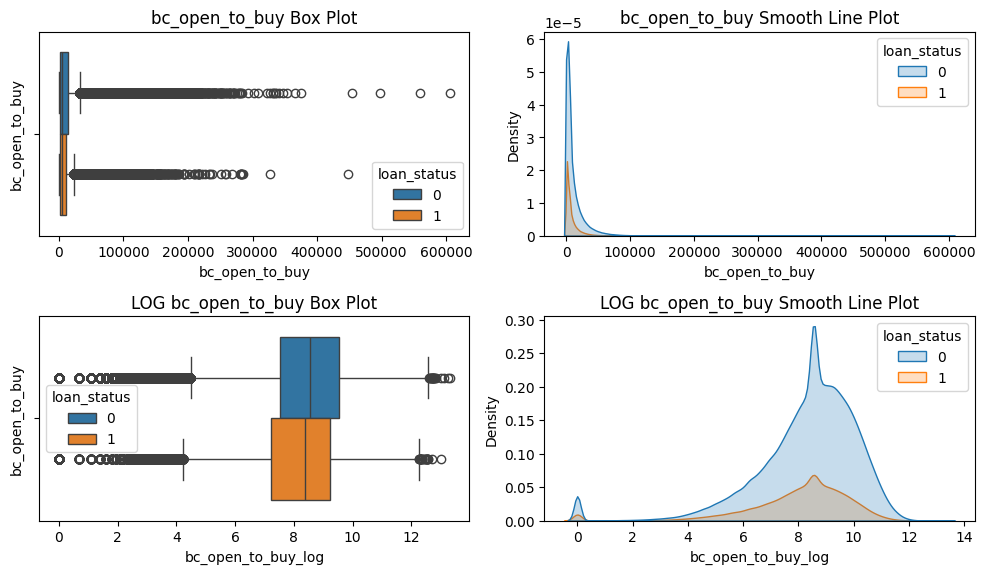

chargeoff_within_12_mths


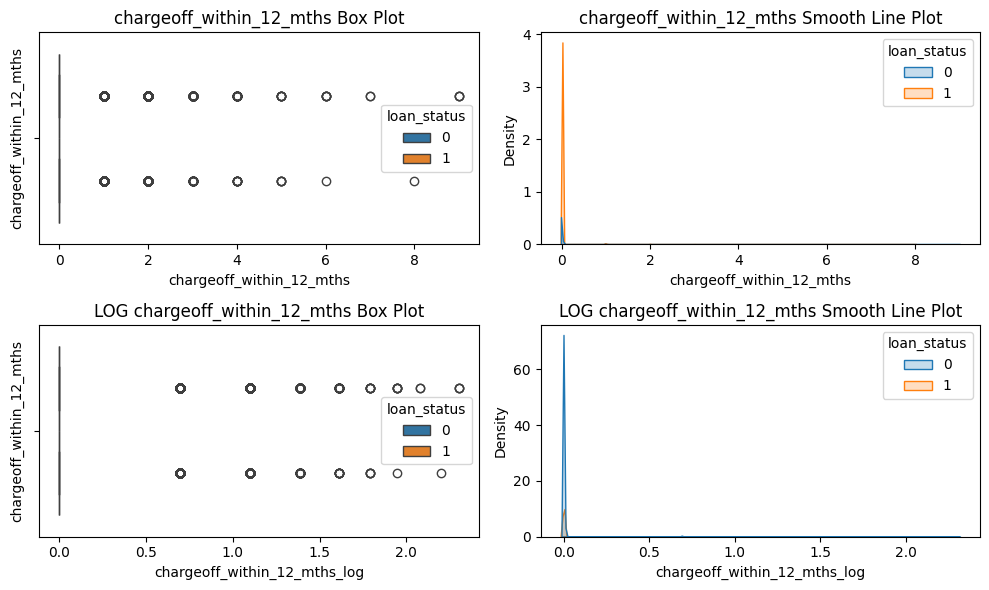

delinq_amnt


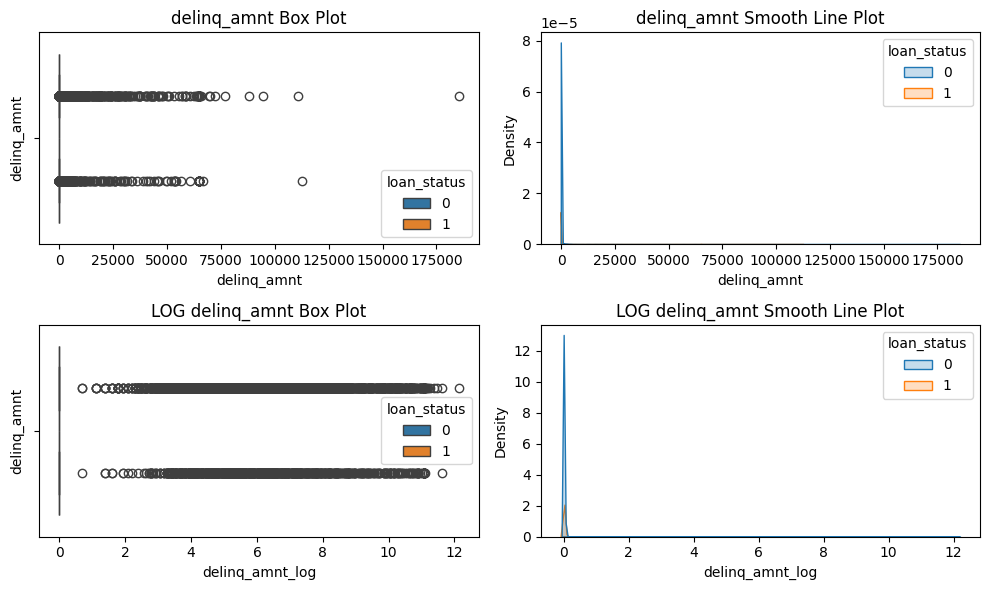

mo_sin_old_il_acct


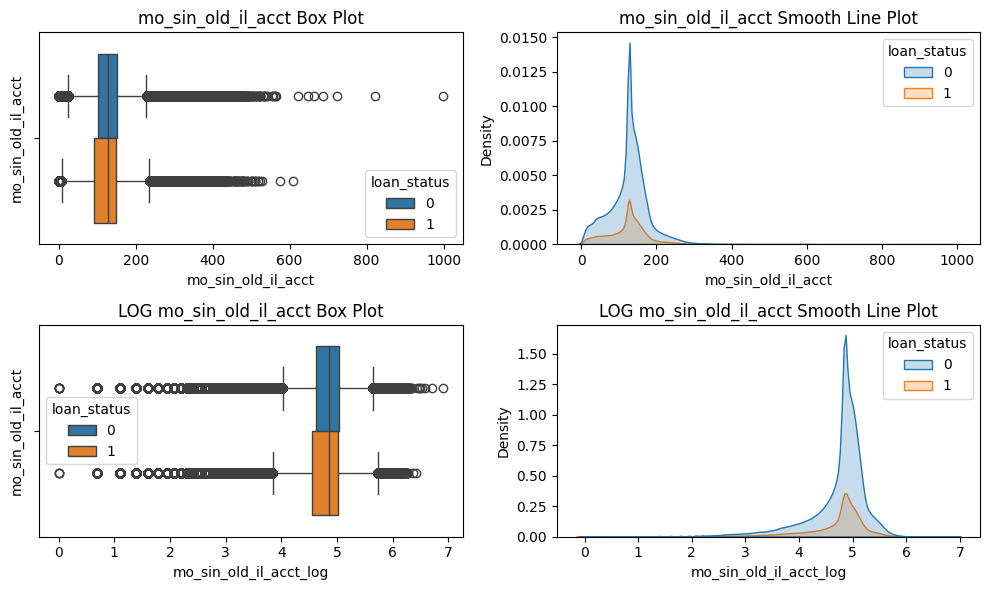

mo_sin_old_rev_tl_op


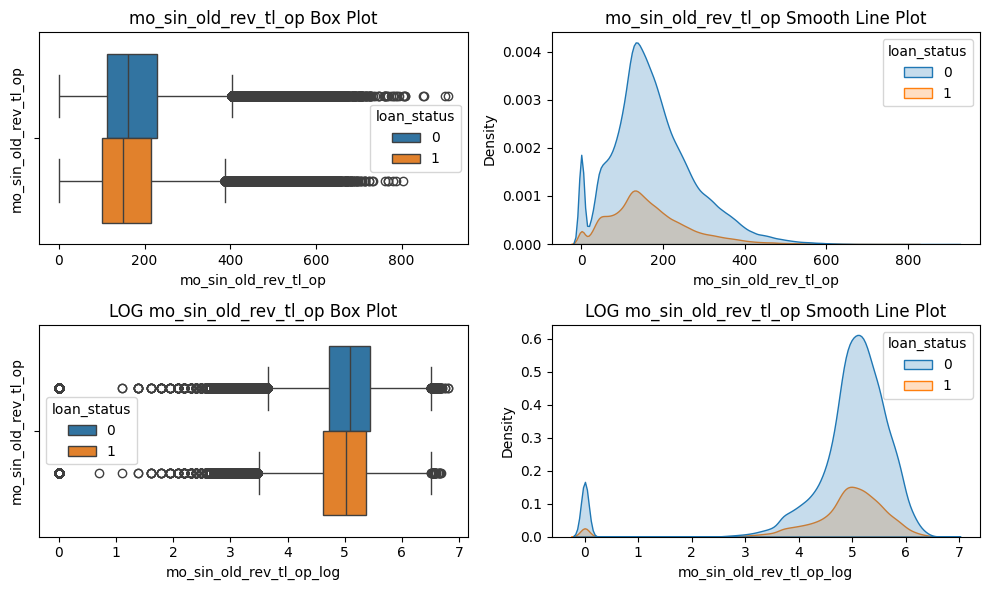

mo_sin_rcnt_rev_tl_op


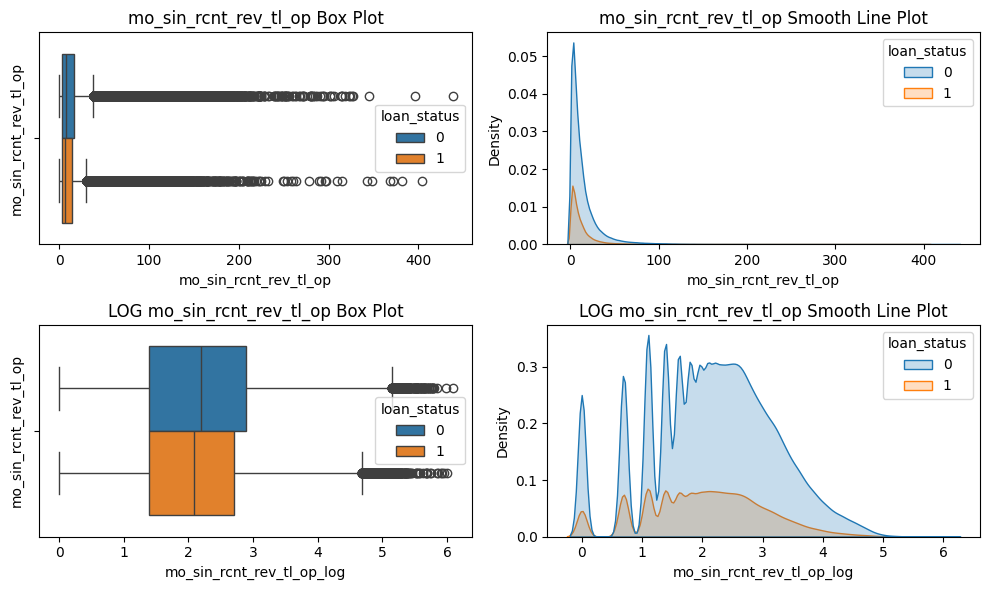

mo_sin_rcnt_tl


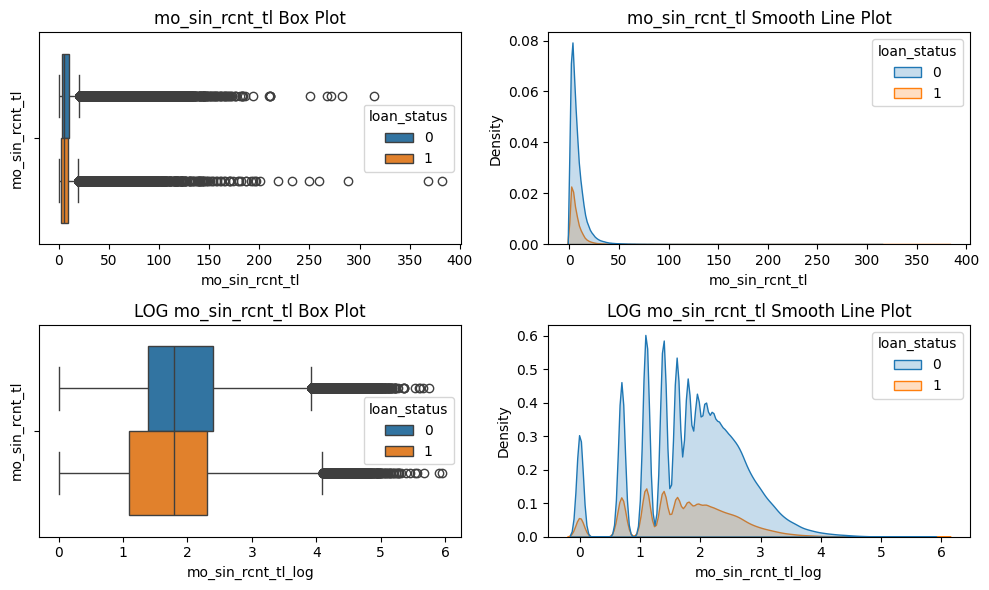

mort_acc


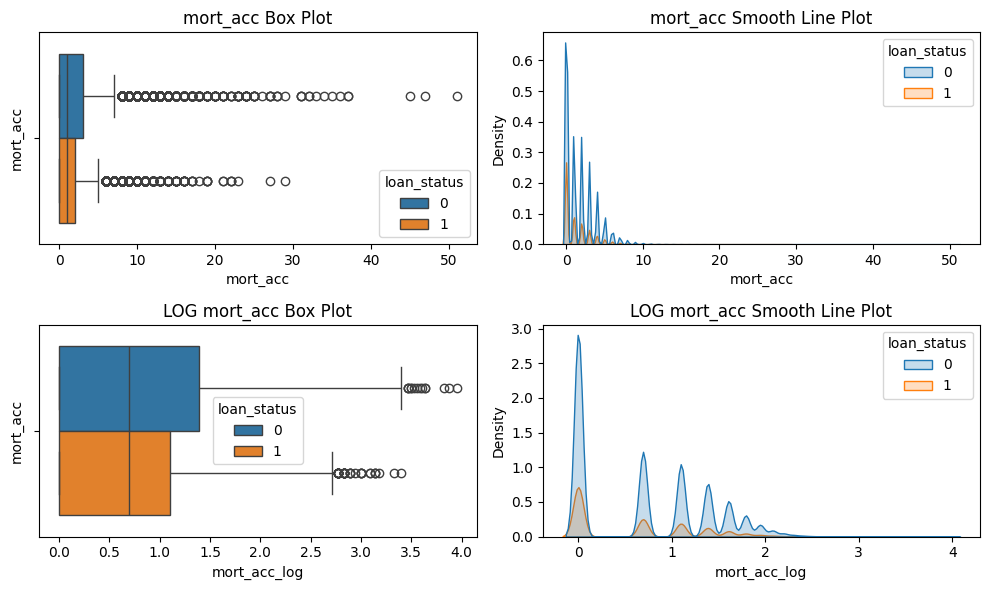

mths_since_recent_bc


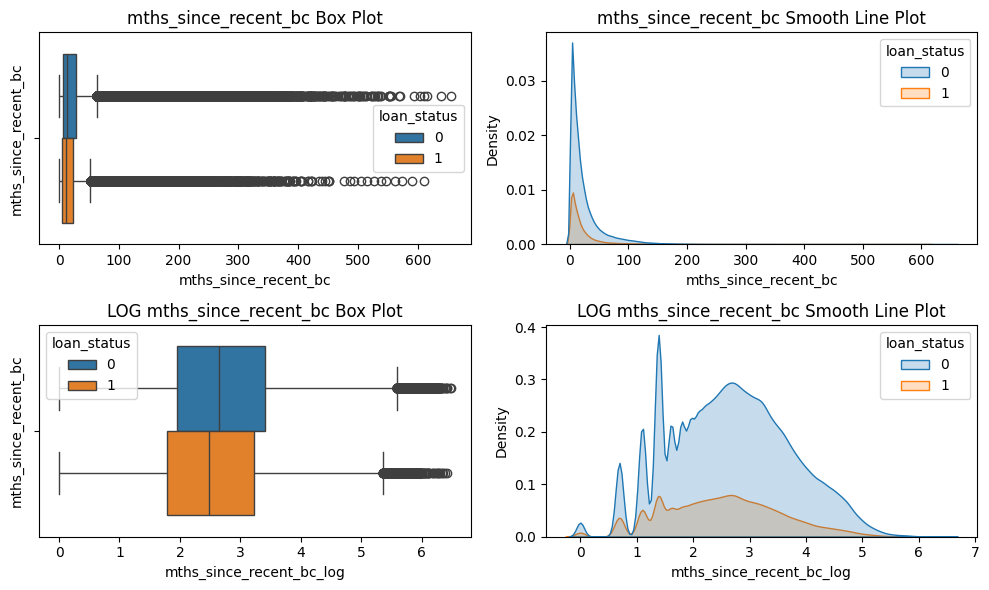

mths_since_recent_inq


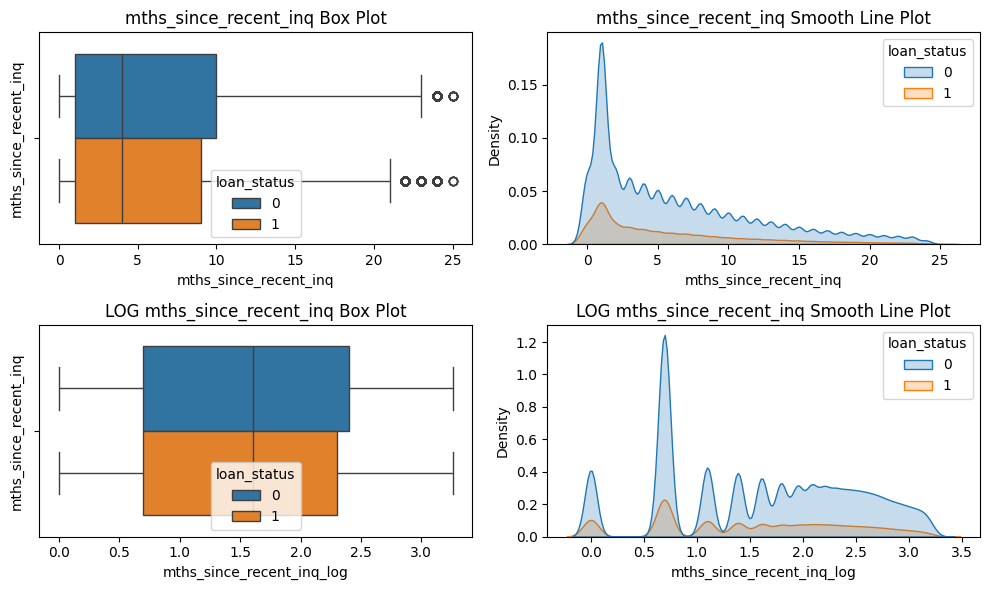

num_accts_ever_120_pd


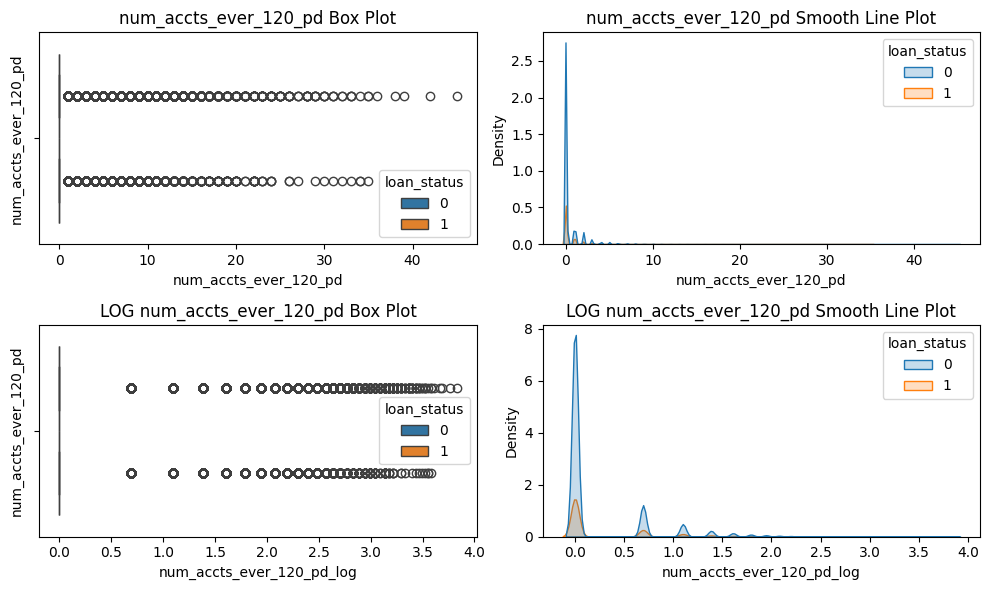

num_actv_bc_tl


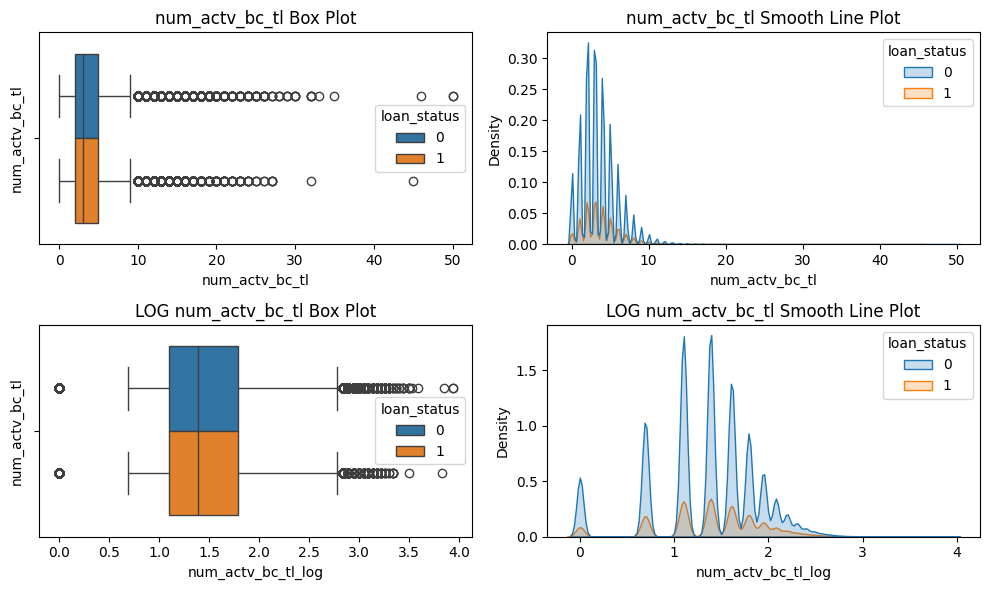

num_actv_rev_tl


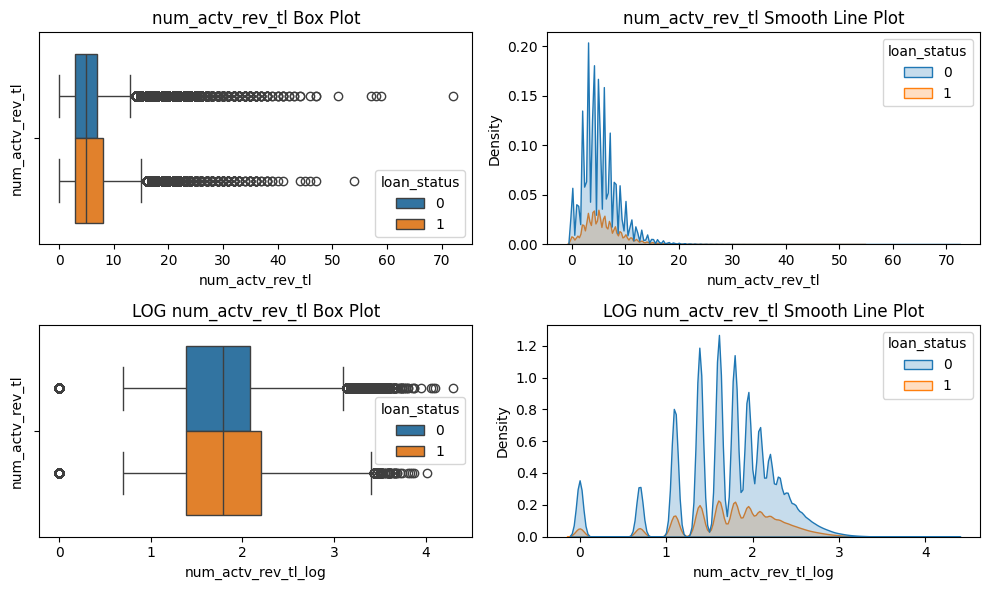

num_bc_sats


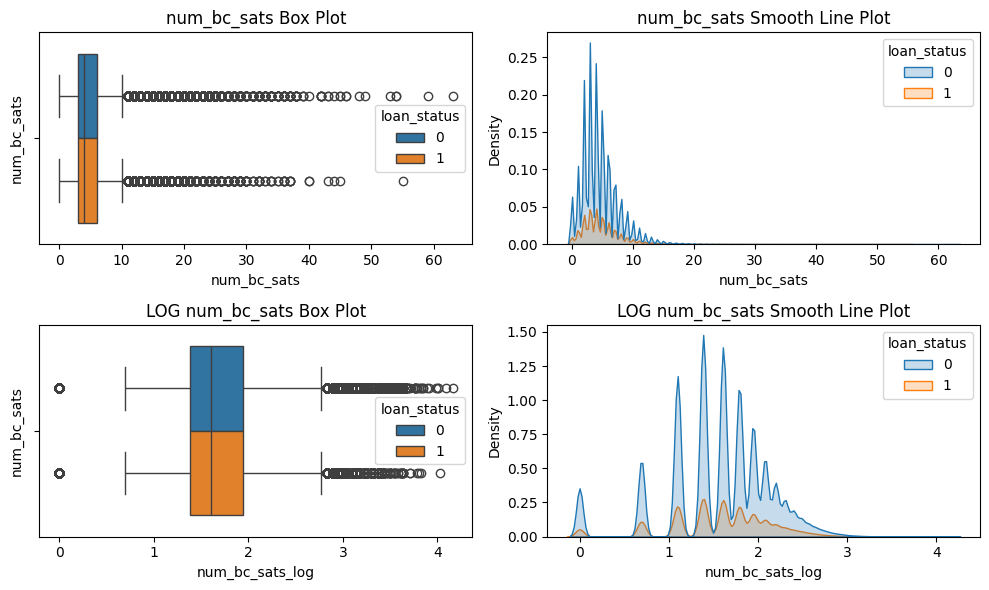

num_bc_tl


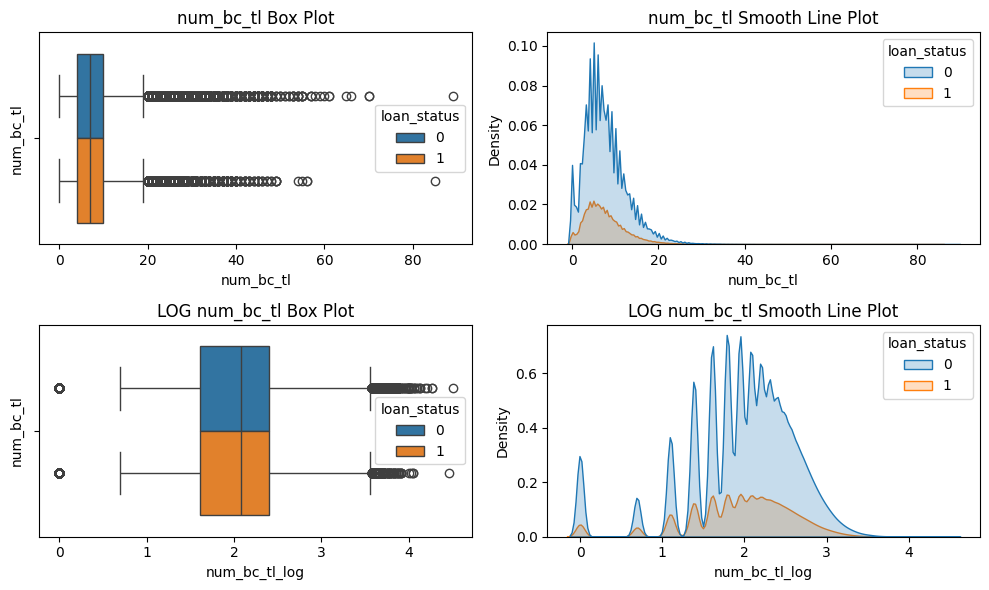

num_il_tl


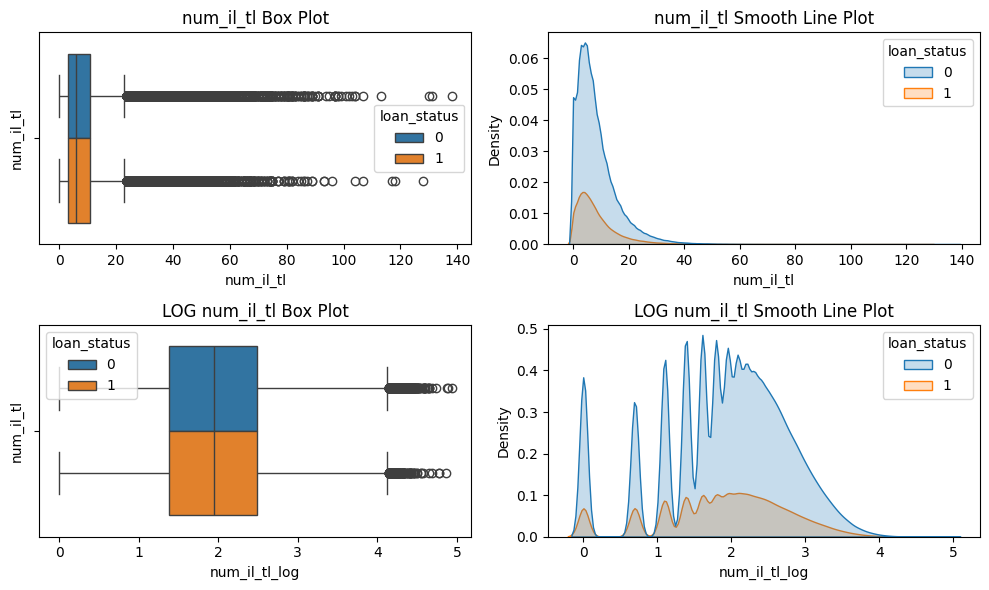

num_op_rev_tl


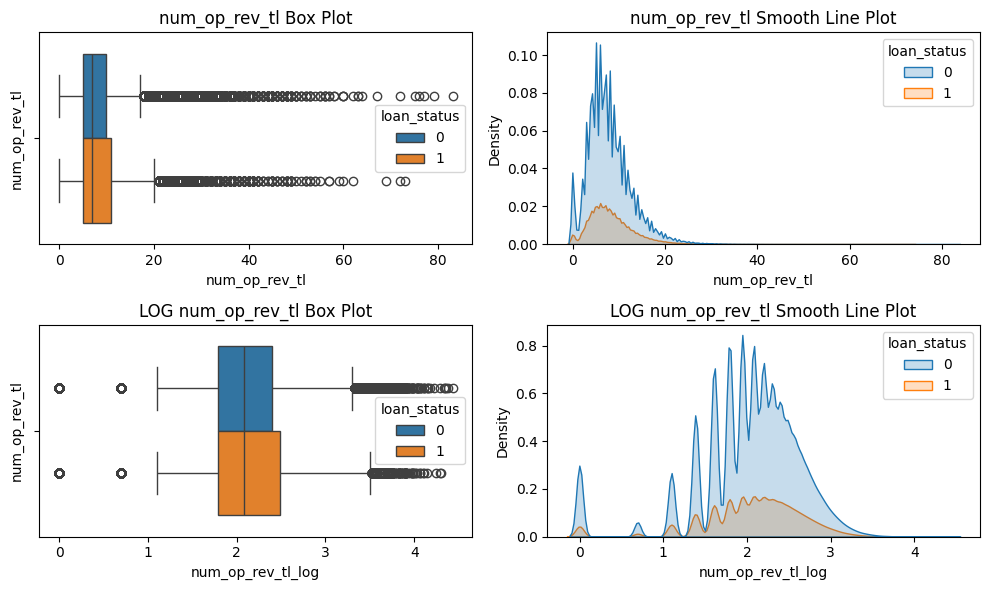

num_rev_accts


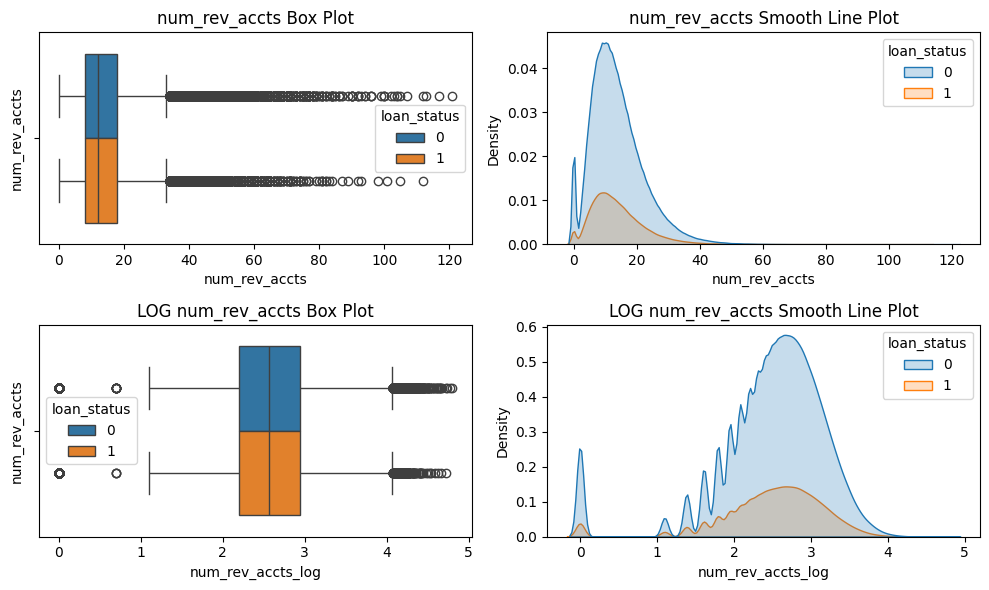

num_rev_tl_bal_gt_0


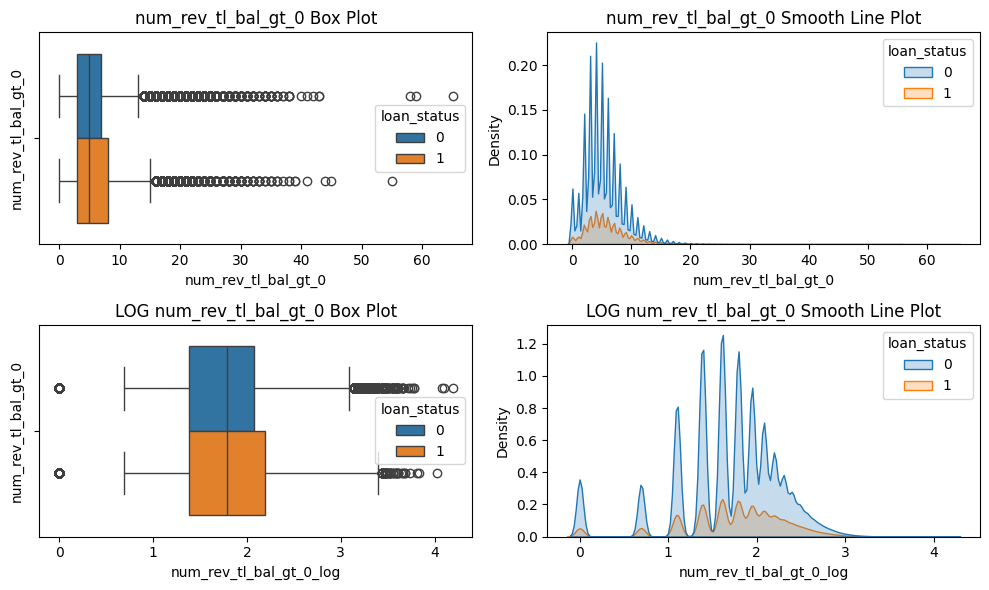

num_sats


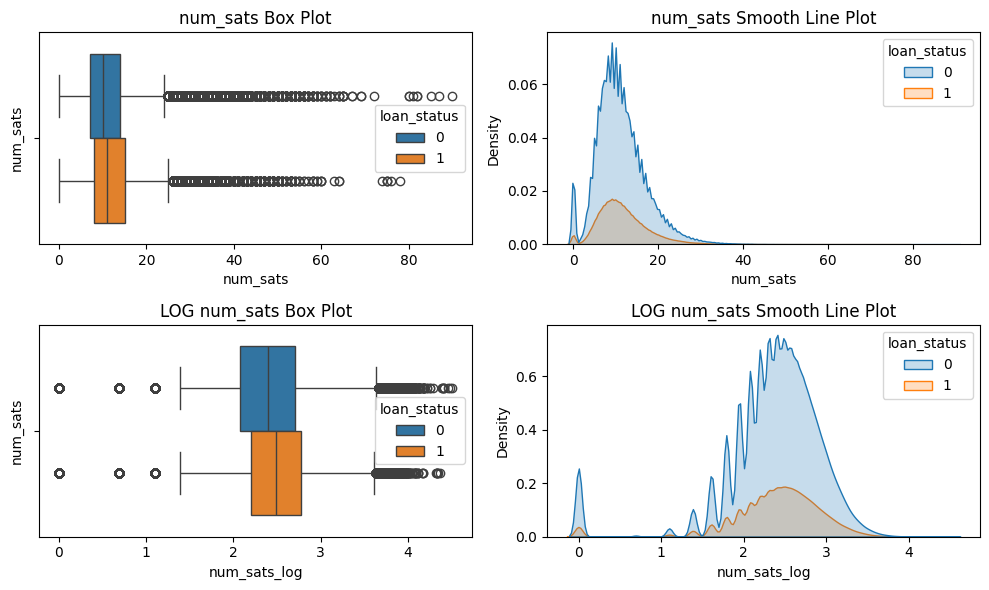

num_tl_120dpd_2m


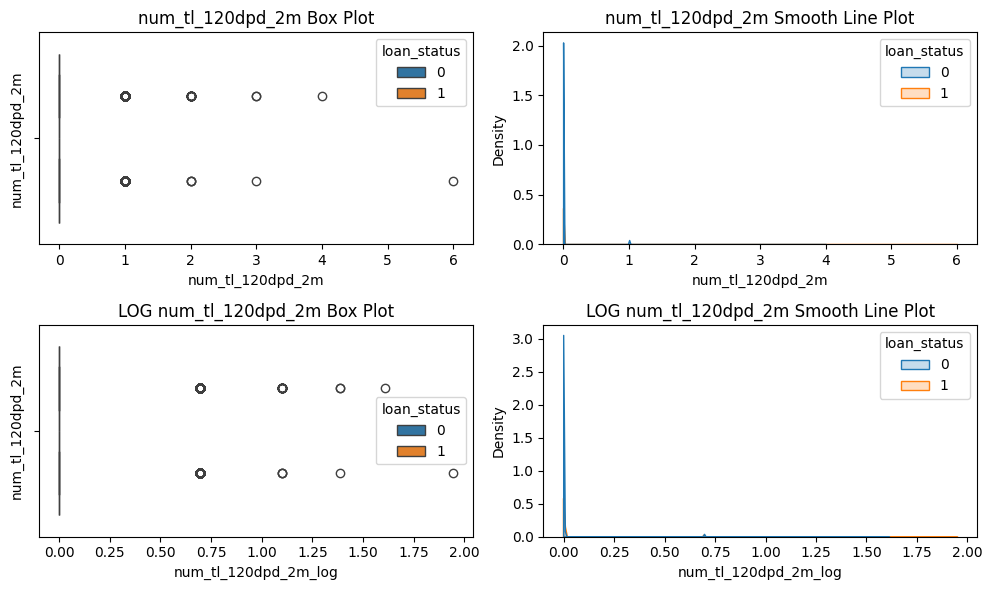

num_tl_30dpd


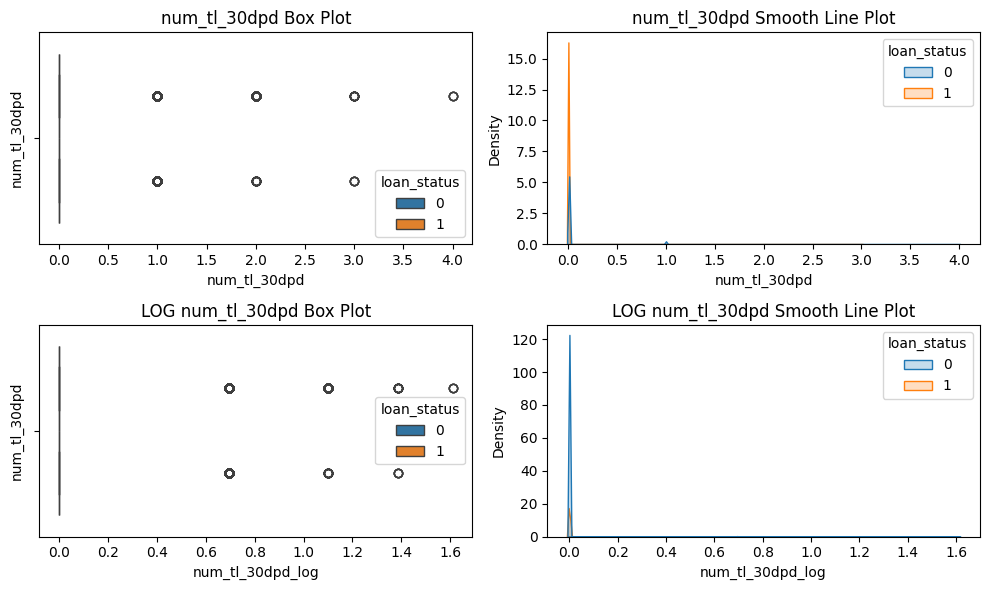

num_tl_90g_dpd_24m


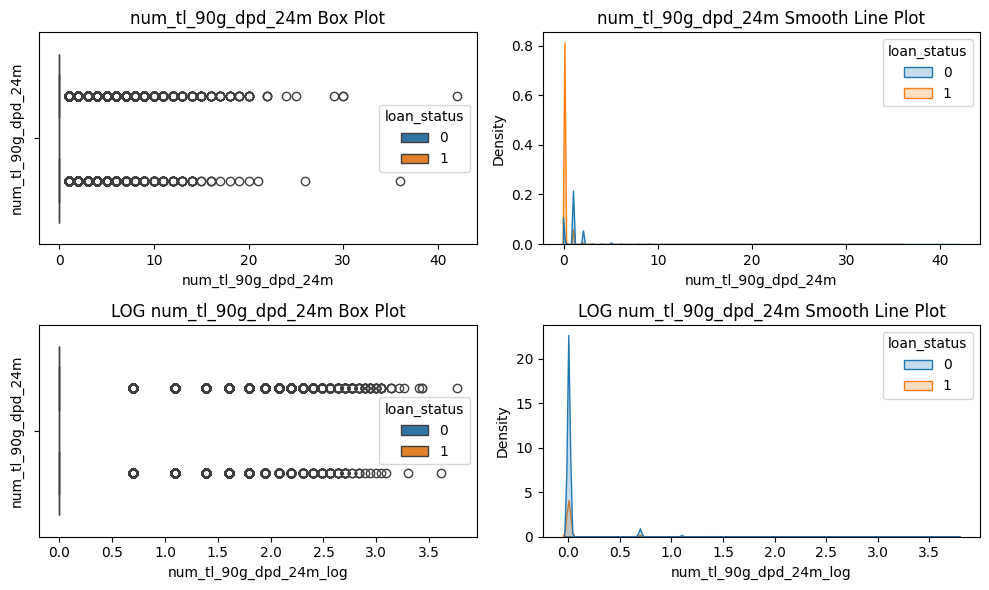

num_tl_op_past_12m


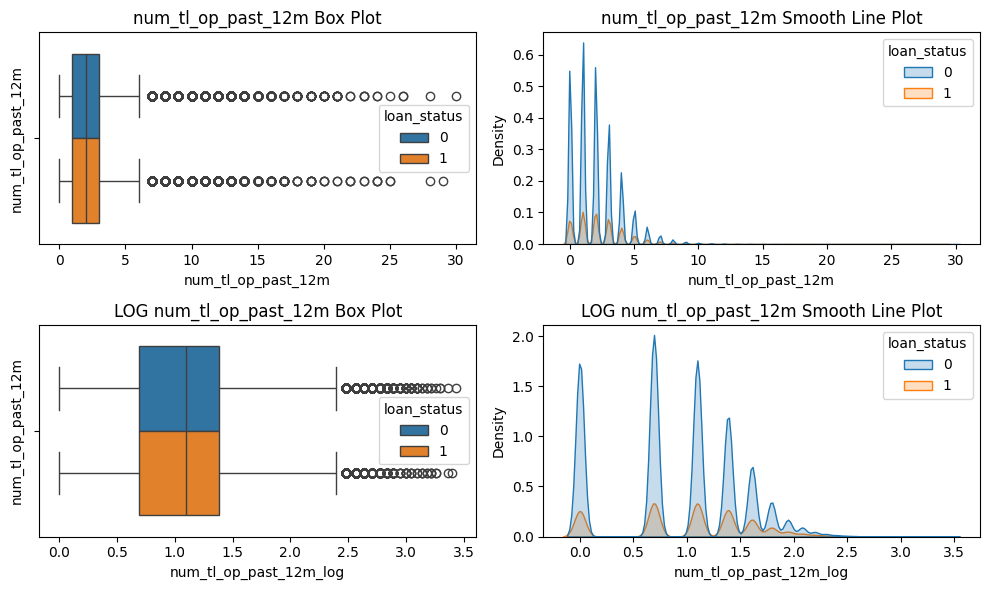

pct_tl_nvr_dlq


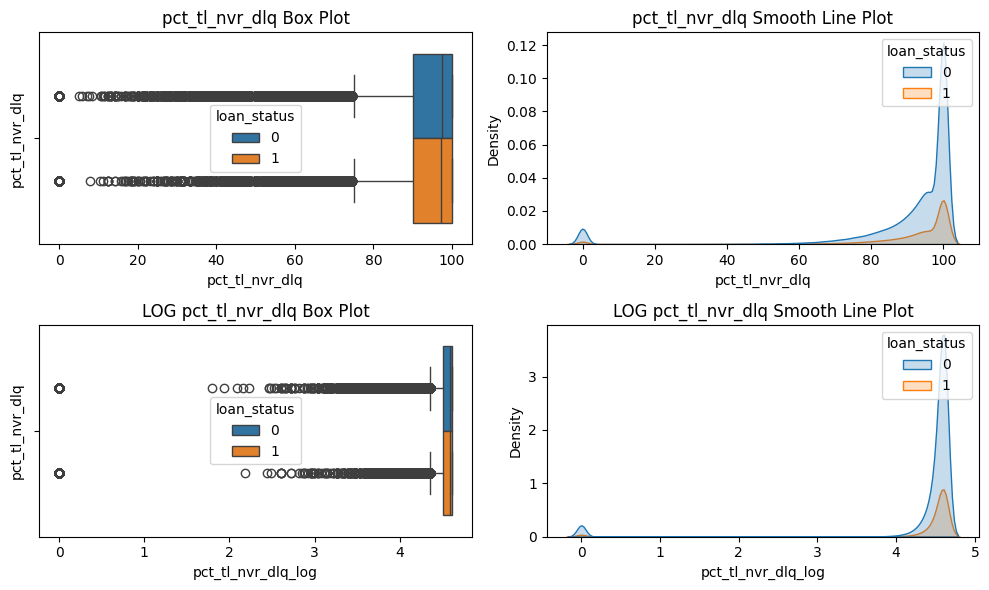

pub_rec_bankruptcies


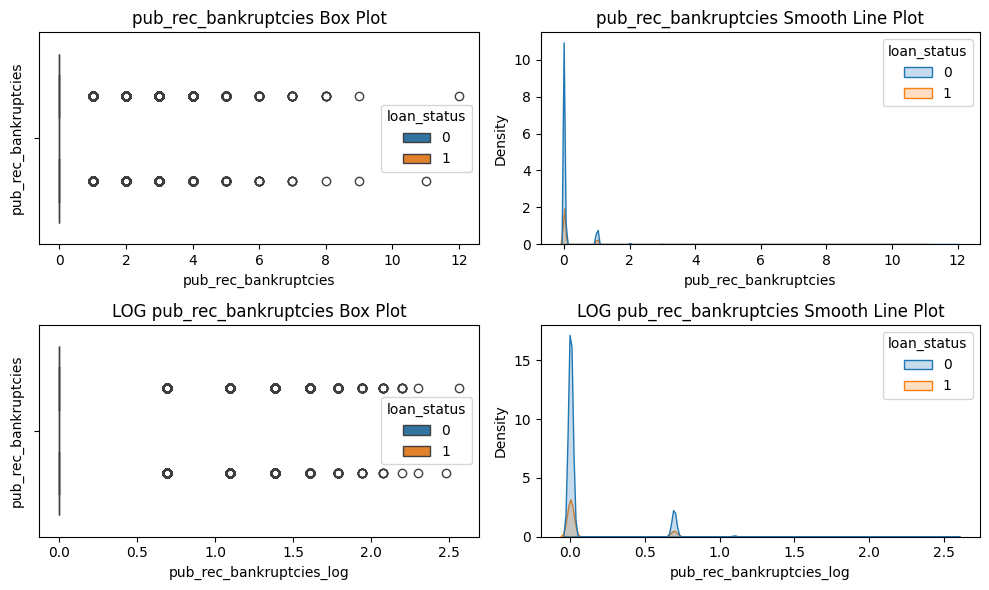

tax_liens


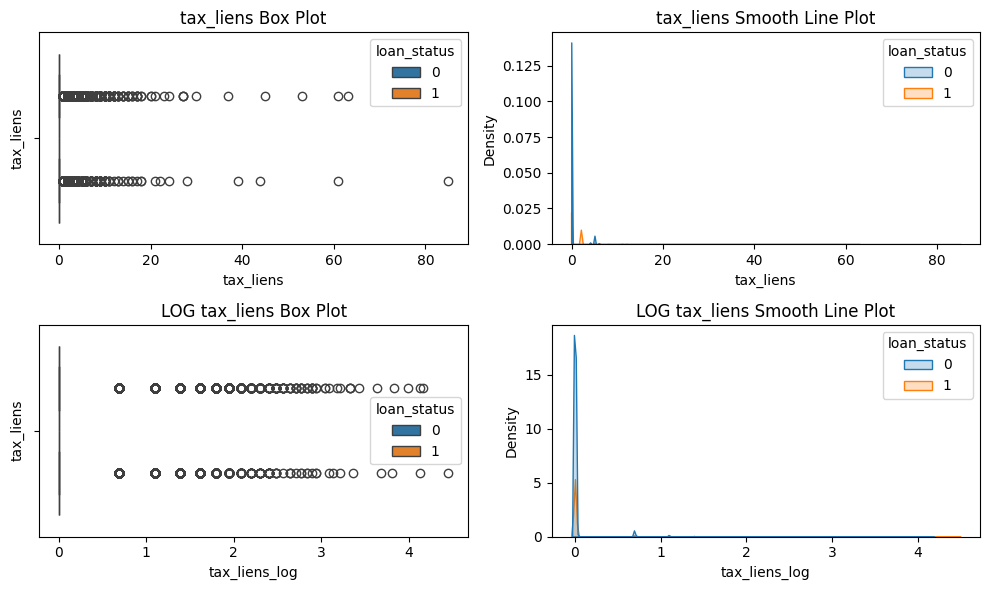

tot_hi_cred_lim


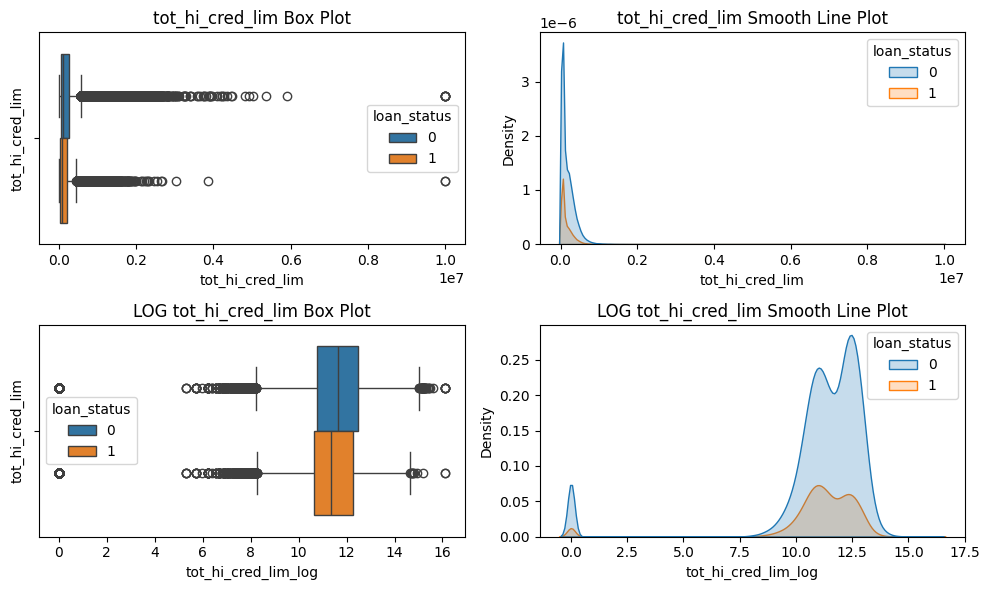

total_bal_ex_mort


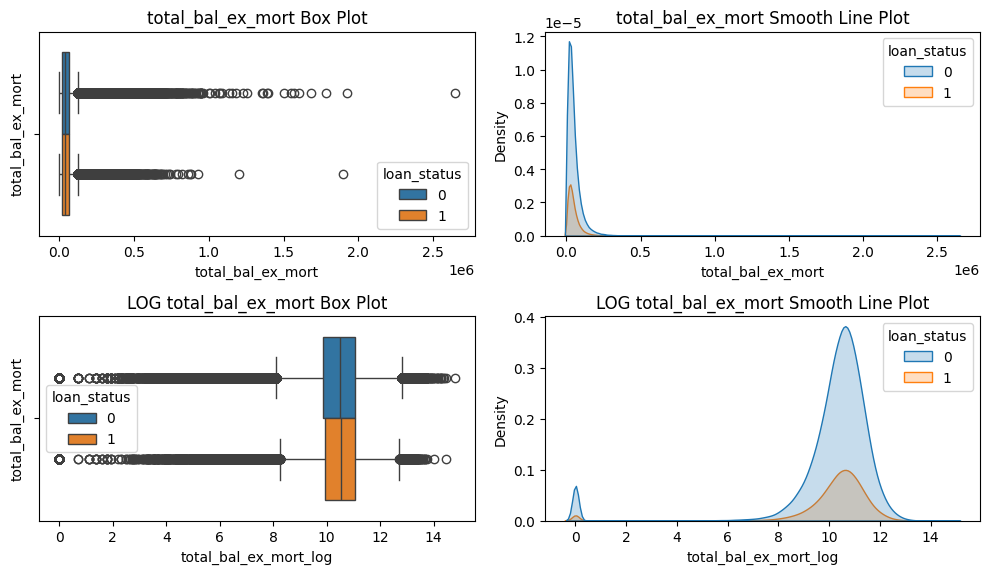

total_bc_limit


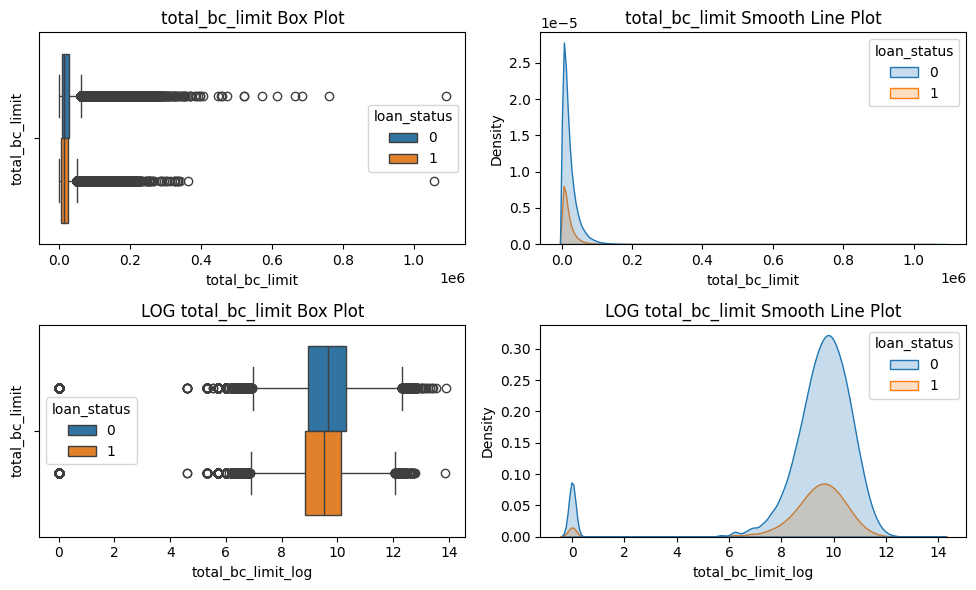

total_il_high_credit_limit


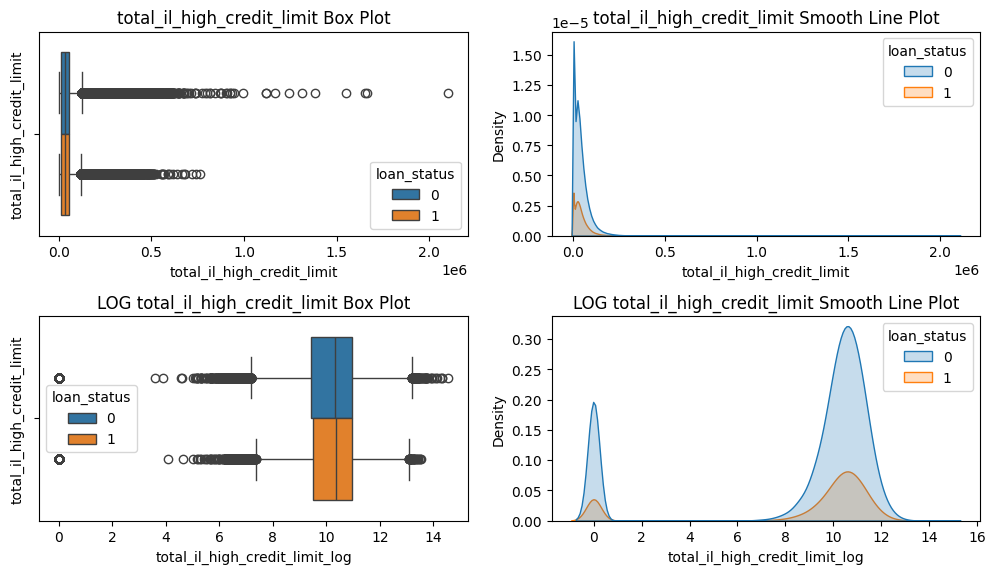

revol_bal_joint


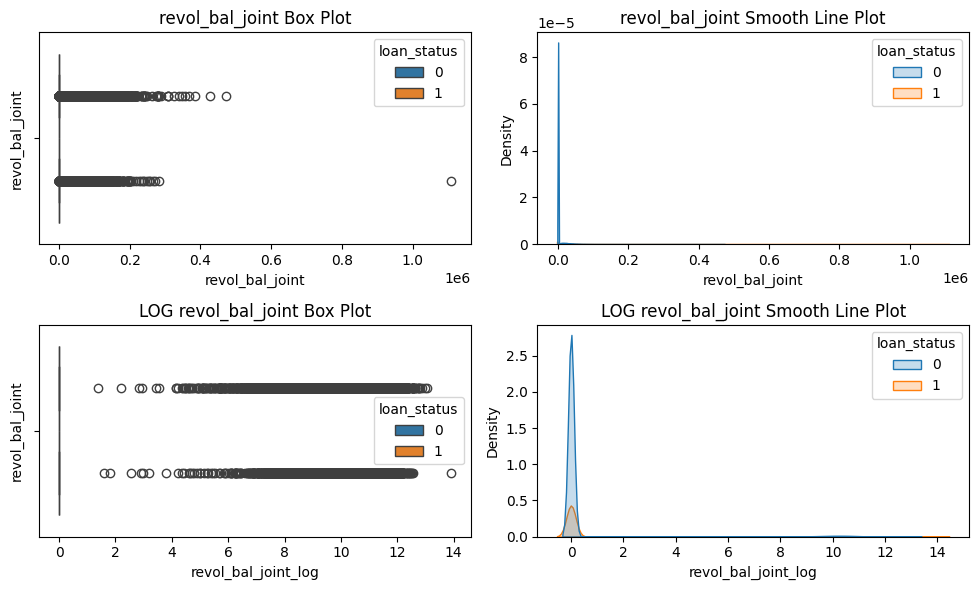

is_after_2015


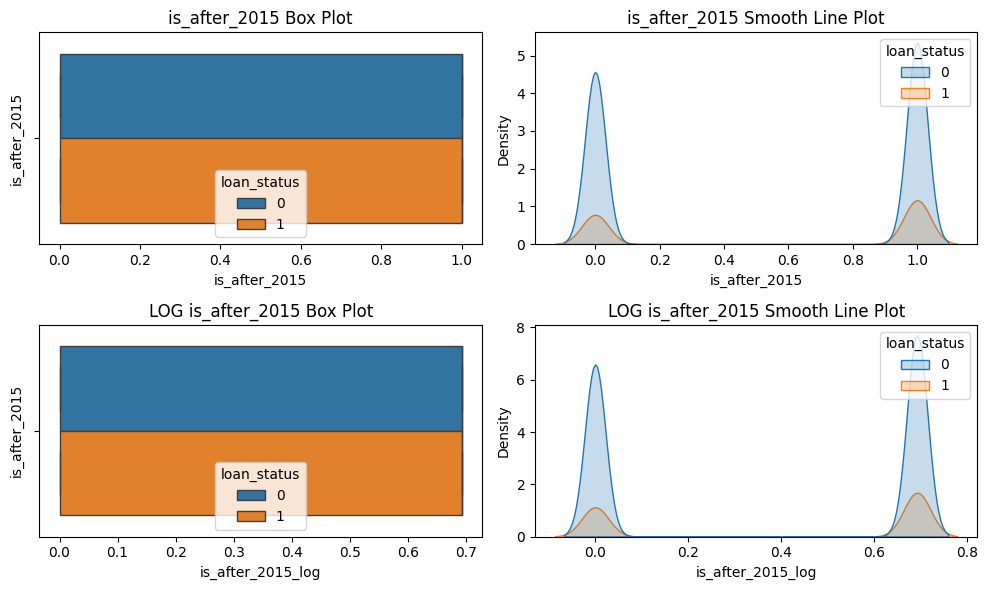

is_after_2012


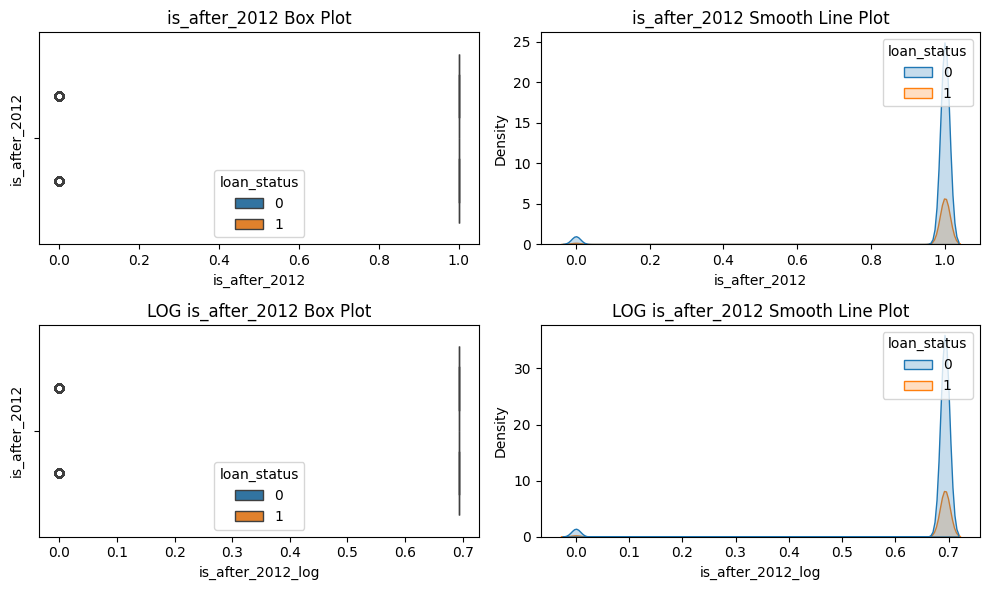

In [ ]:
## 2. 로그 표시
#plot numerical variable using booxplot and histogram (smothing line for an easier visualization)
for col in df.select_dtypes('number'):
    if col == 'loan_status':
      continue
    print(col)
    plt.figure(figsize=(10, 6))

    df_v = df[[col,'loan_status']]
    df_v['{}_log'.format(col)] = df_v[col].apply(log_transform)

    # Box plot
    plt.subplot(2, 2, 1)
    sns.boxplot(data=df_v, x=col, hue='loan_status')


    # sns.histplot(data=df_v, x='{}_log'.format(variable), hue='loan_status', bins=50, multiple='stack')
    plt.title(col + ' Box Plot')
    plt.ylabel(col)

    # Smooth line plot
    plt.subplot(2, 2, 2)
    sns.kdeplot(data=df, x=col, fill=True, hue='loan_status')
    plt.title(col + ' Smooth Line Plot')
    plt.xlabel(col)
    plt.ylabel('Density')

    # Box plot - log
    plt.subplot(2, 2, 3)
    sns.boxplot(data=df_v, x= '{}_log'.format(col), hue='loan_status')
    plt.title('LOG ' + col + ' Box Plot')
    plt.ylabel(col)

    # Smooth line plot - log
    plt.subplot(2, 2, 4)
    sns.kdeplot(data=df_v, x='{}_log'.format(col), fill=True, hue='loan_status')#, stack=True)
    plt.title('LOG ' + col + ' Smooth Line Plot')
    plt.xlabel('{}_log'.format(col))
    plt.ylabel('Density')

    plt.tight_layout()
    plt.show()

- 범주형 변수의 pie plot

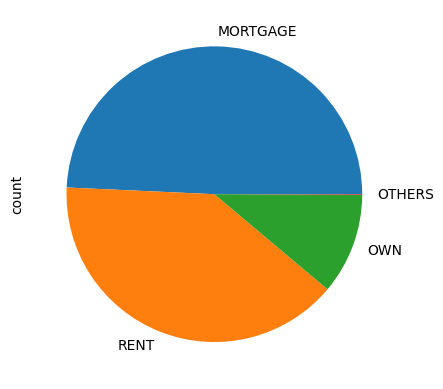

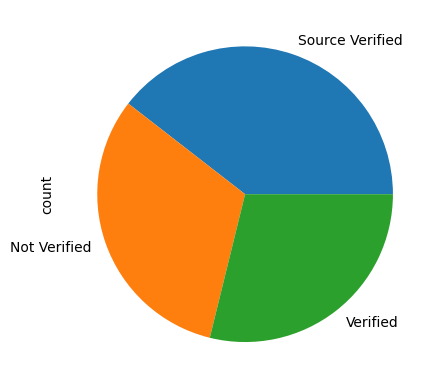

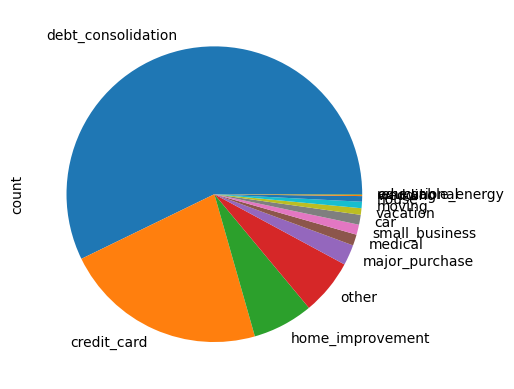

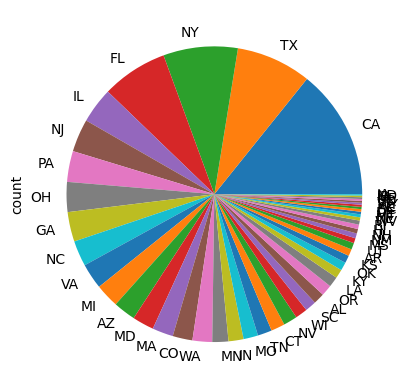

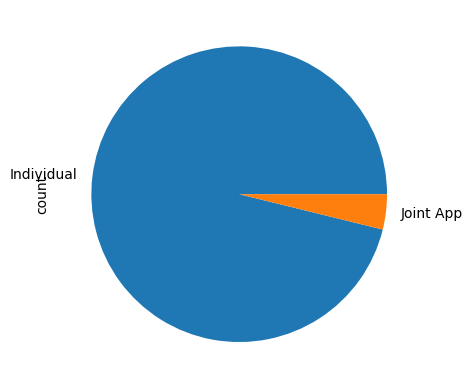

In [ ]:
# 범주형 변수 확인
for col in df.select_dtypes('object'):
    plt.figure()
    df[col].value_counts().plot.pie()

sub_grade


<ipython-input-14-c2f118c972e4>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_v['{}_log'.format(col)] = df_v[col].apply(log_transform)


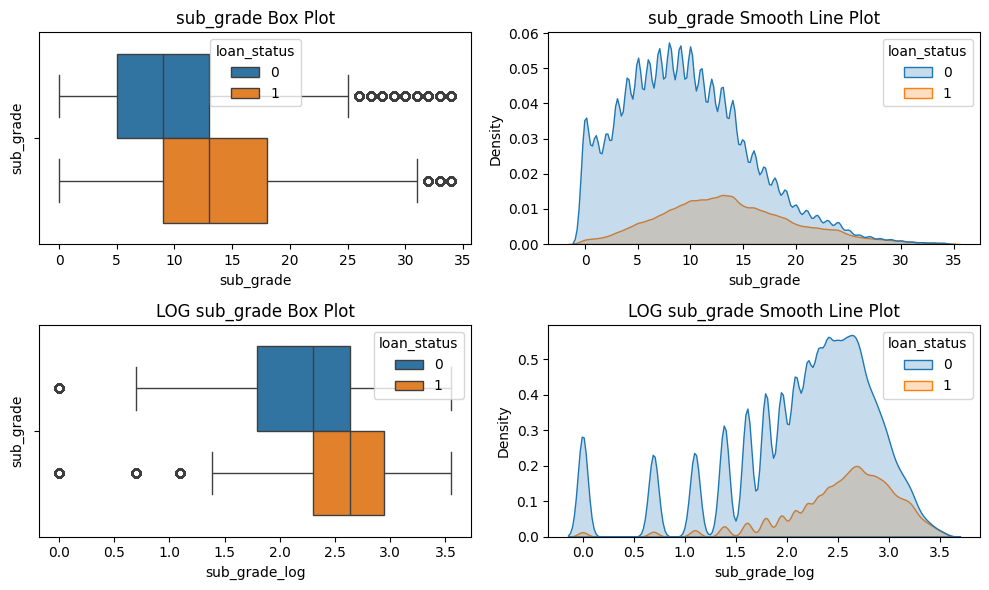

In [ ]:
## 2. 로그 표시
#plot numerical variable using booxplot and histogram (smothing line for an easier visualization)
col = 'sub_grade'
print(col)
plt.figure(figsize=(10, 6))

df_v = df[[col,'loan_status']]
df_v['{}_log'.format(col)] = df_v[col].apply(log_transform)

# Box plot
plt.subplot(2, 2, 1)
sns.boxplot(data=df_v, x=col, hue='loan_status')


# sns.histplot(data=df_v, x='{}_log'.format(variable), hue='loan_status', bins=50, multiple='stack')
plt.title(col + ' Box Plot')
plt.ylabel(col)

# Smooth line plot
plt.subplot(2, 2, 2)
sns.kdeplot(data=df, x=col, fill=True, hue='loan_status')
plt.title(col + ' Smooth Line Plot')
plt.xlabel(col)
plt.ylabel('Density')

# Box plot - log
plt.subplot(2, 2, 3)
sns.boxplot(data=df_v, x= '{}_log'.format(col), hue='loan_status')
plt.title('LOG ' + col + ' Box Plot')
plt.ylabel(col)

# Smooth line plot - log
plt.subplot(2, 2, 4)
sns.kdeplot(data=df_v, x='{}_log'.format(col), fill=True, hue='loan_status')#, stack=True)
plt.title('LOG ' + col + ' Smooth Line Plot')
plt.xlabel('{}_log'.format(col))
plt.ylabel('Density')

plt.tight_layout()
plt.show()